# Prediction of clinical readmissions in patients with diabetes

**Name:** Carlos Alberto Arbelaez Giraldo

**ID:** 1017212109

**e-mail:** carlos.arbelaezg@udea.edu.co

-------------------------------------------------------
**Name:** Santiago Velásquez 

**ID:**  1036647710

**e-mail:** santiago.velasquez4@udea.edu.co



### Problem description

It is important to know if a patient will be readmitted in some hospital. The reason is that you can change the treatment, in order to avoid a readmission.

In this database, you have 3 different outputs:

1. No readmission;
2. A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last one, however, the reason can be the state of the patient.

### Source

The data are submitted on behalf of the Center for Clinical and Translational Research, Virginia Commonwealth University, a recipient of NIH CTSA grant UL1 TR00058 and a recipient of the CERNER data. John Clore (jclore '@' vcu.edu), Krzysztof J. Cios (kcios '@' vcu.edu), Jon DeShazo (jpdeshazo '@' vcu.edu), and Beata Strack (strackb '@' vcu.edu). This data is a de-identified abstract of the Health Facts database (Cerner Corporation, Kansas City, MO).

### Kaggle Link

https://www.kaggle.com/brandao/diabetes

# 1. Imports and configurations

In [1]:
# Exploration and cleaning packages
#========================================================

import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
sns.set_theme()



# 2. Data cleaning and exploration

In [2]:
df = pd.read_csv('../data/raw/diabetic_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

From **df.info()** can be noticed that there's no null values, besides that we will double check it.

### Search of null/NaN values

In [3]:
if (df.isna().sum().sum() == 0):
    print("There's not NaN values")
else:
    df.isna().sum()

There's not NaN values


In [4]:
if (df.isnull().sum().sum() == 0):
    print("There's not null values")
else:
    df.isnull().sum()

There's not null values


### Help with the inferences
In order to have a better aproach in the analysis we want to use sweetviz as a tool to have better information about all variables

#### Generating an exploratory data analysis report

In [5]:
eda_report = sv.analyze(df)


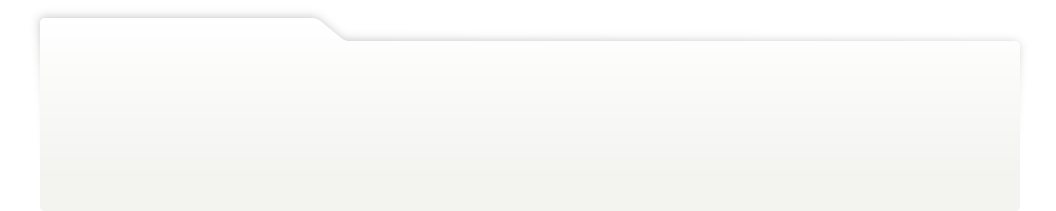
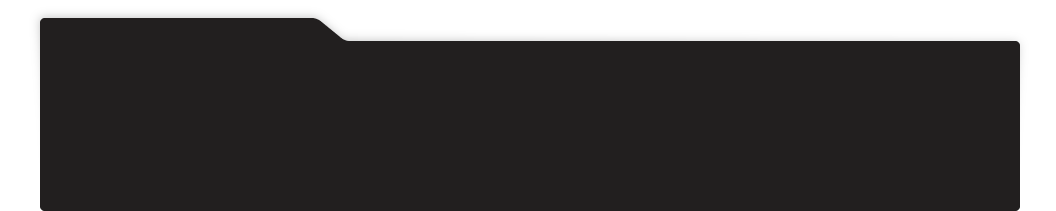
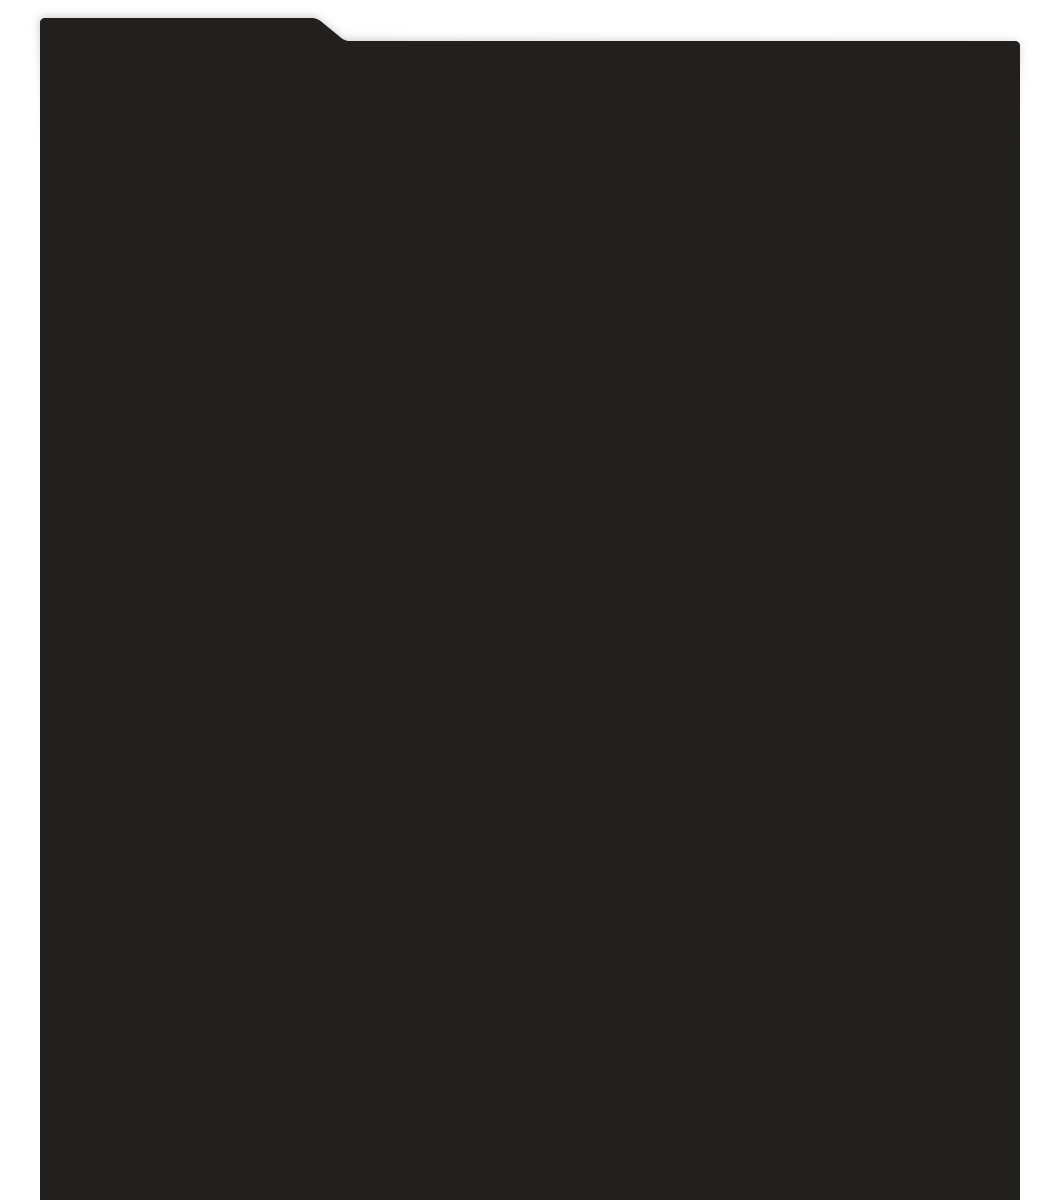
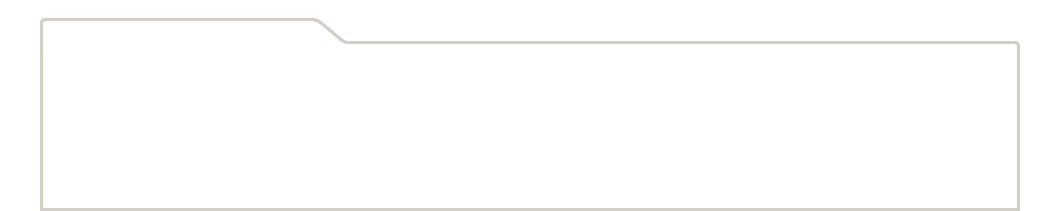
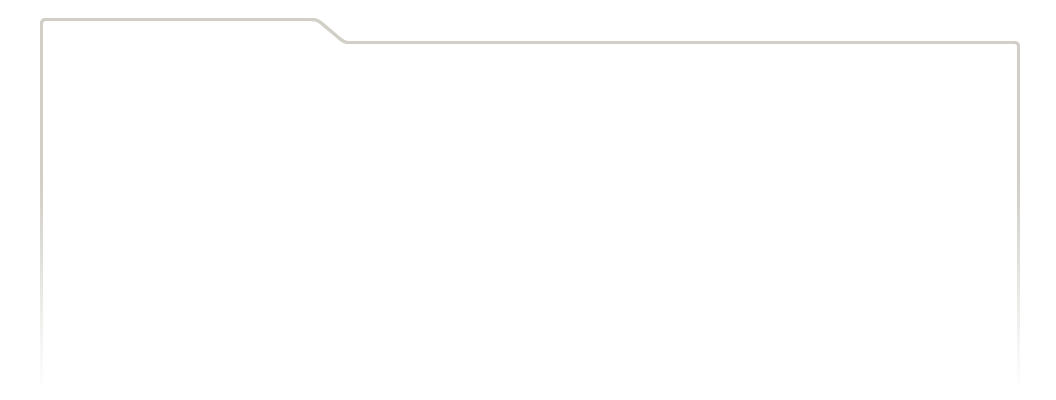
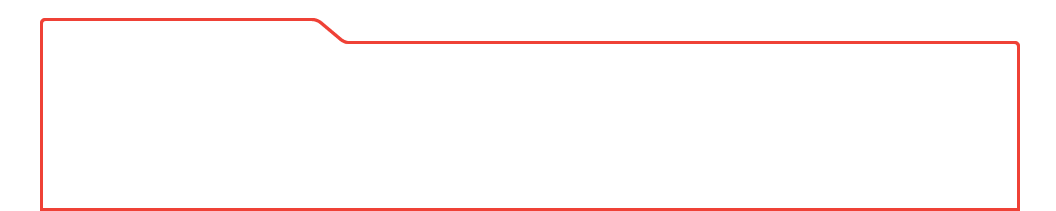
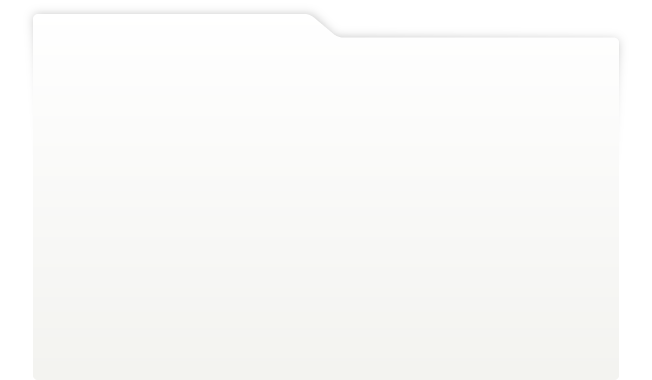
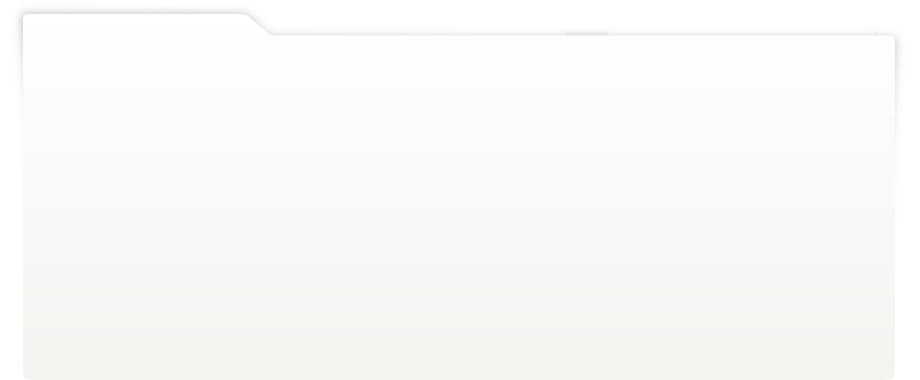
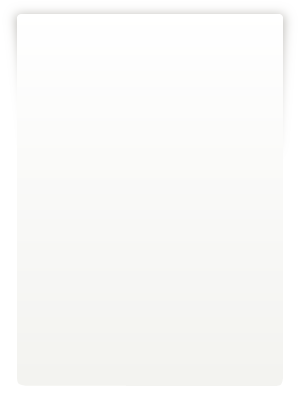
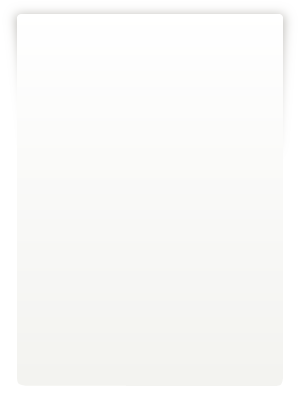
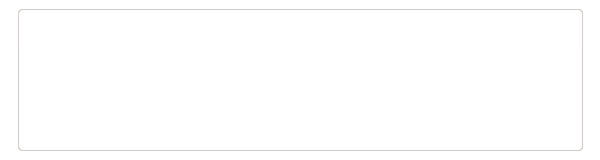
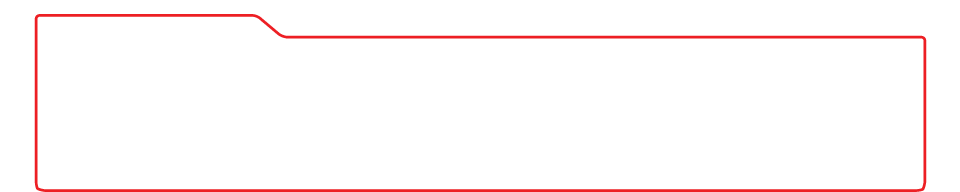
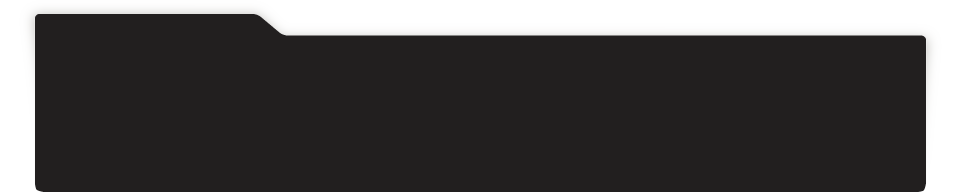
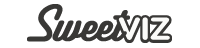
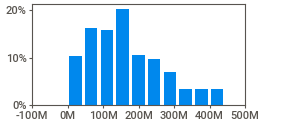
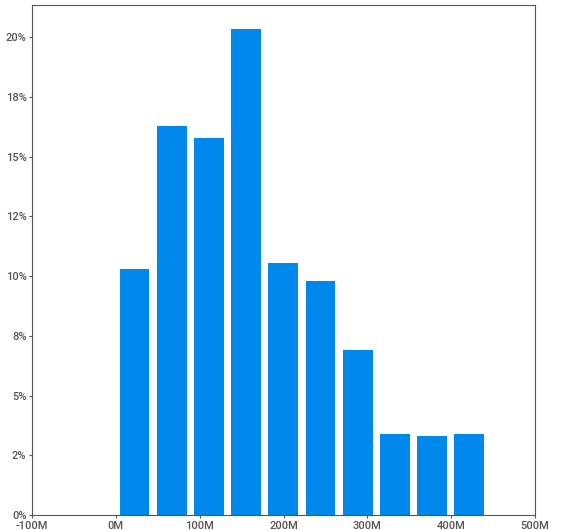
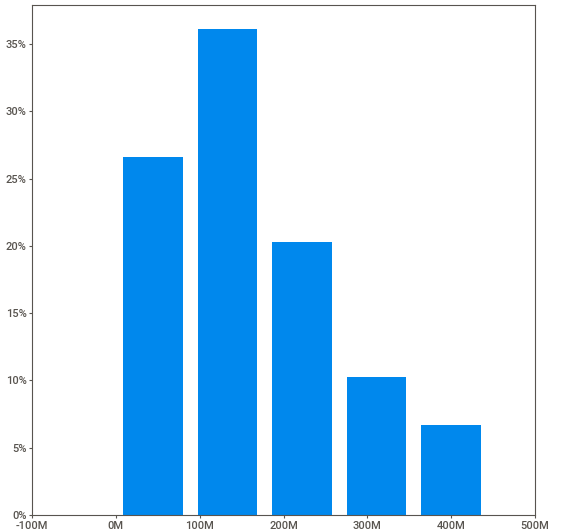
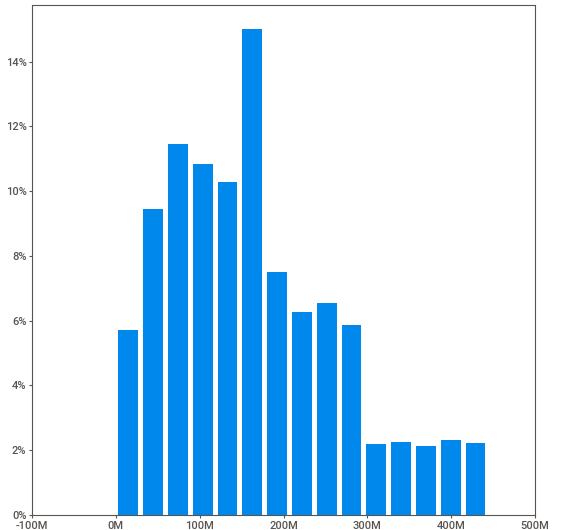
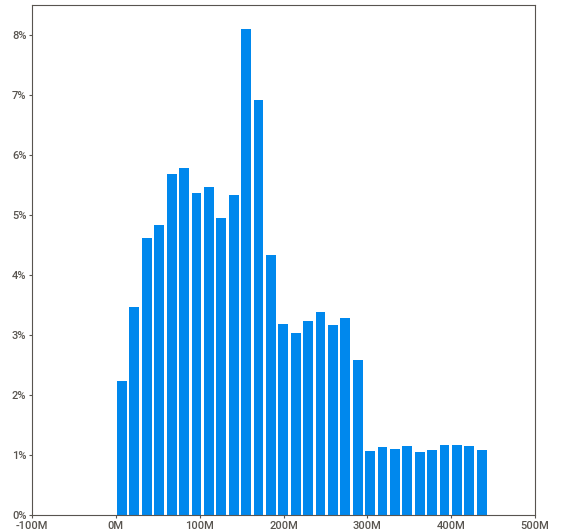
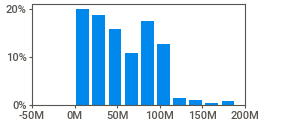
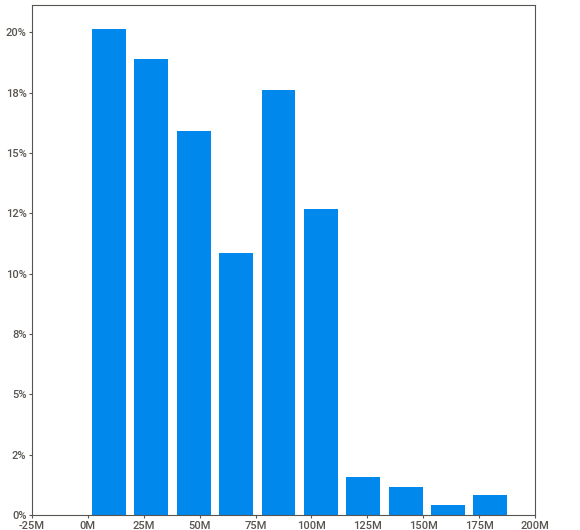
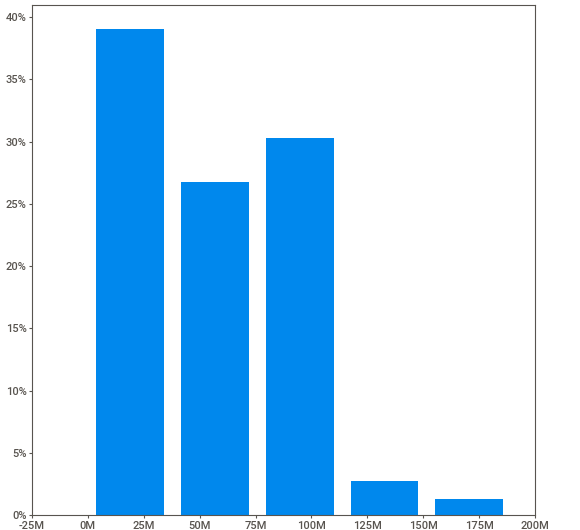
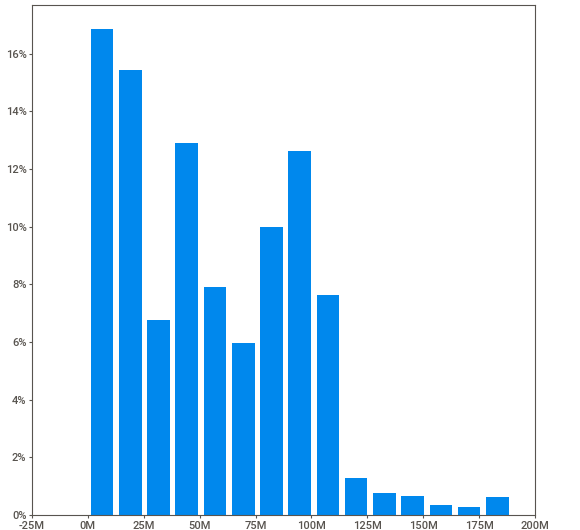
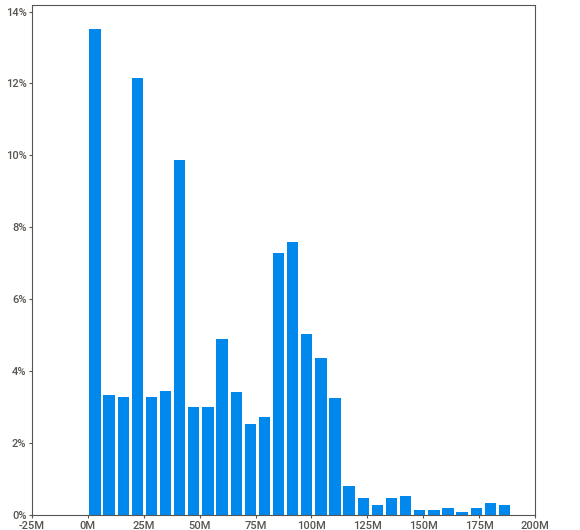
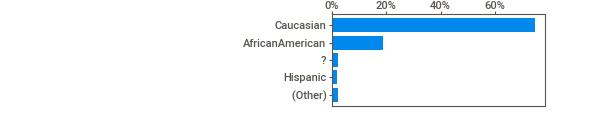
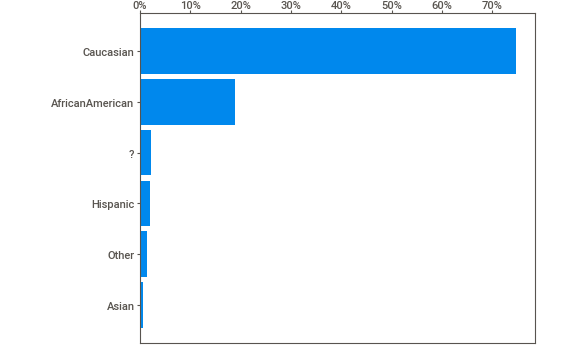
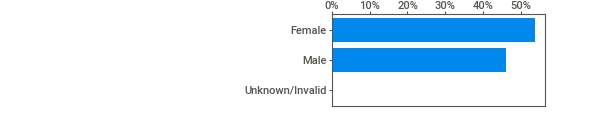
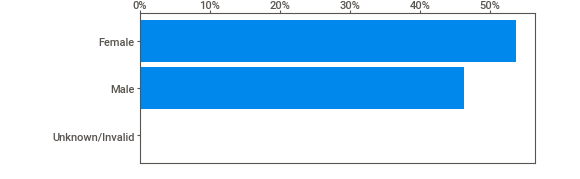
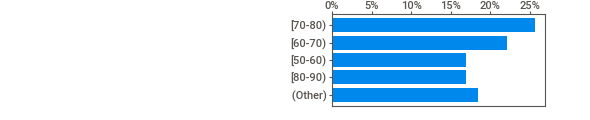
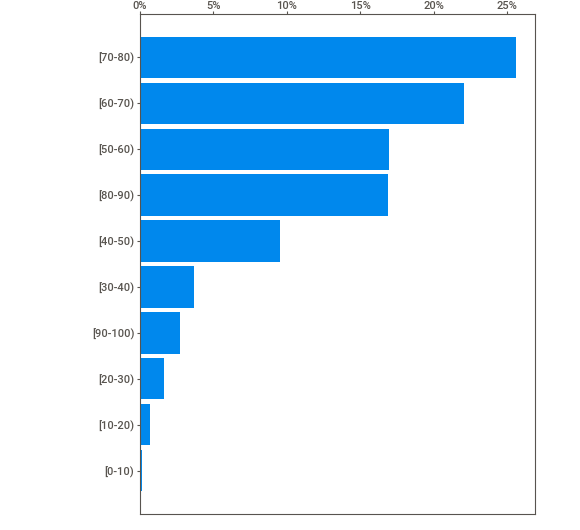
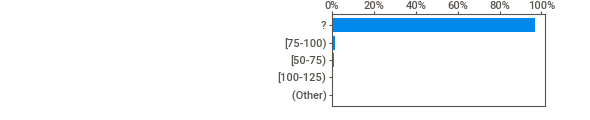
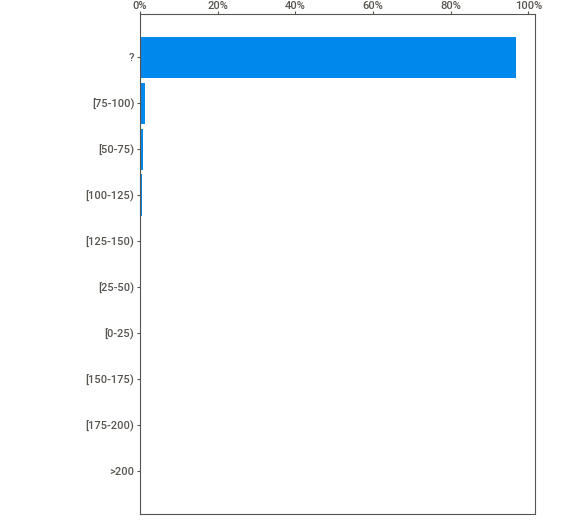
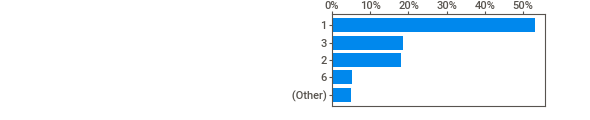
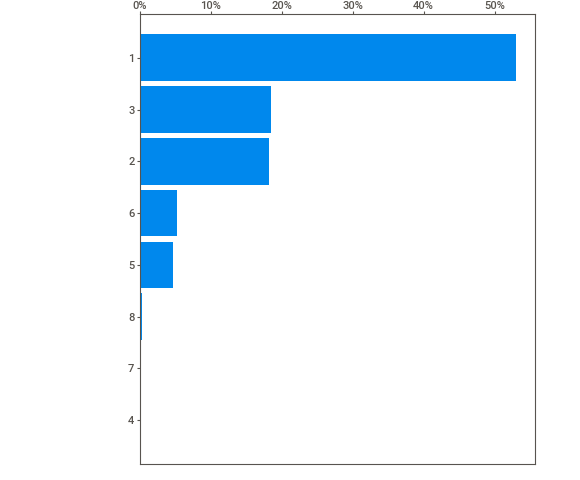
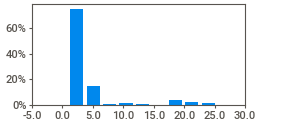
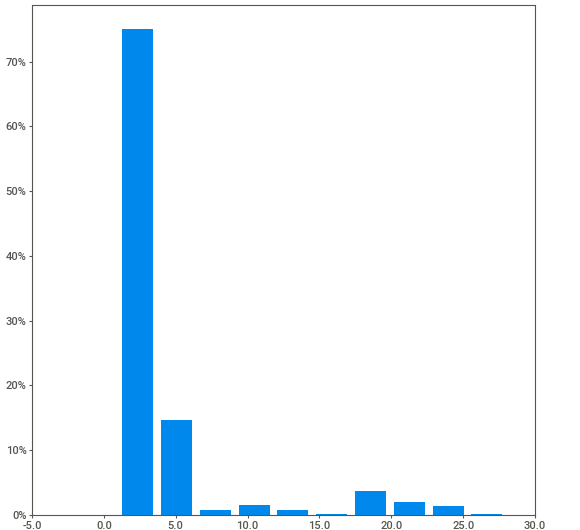
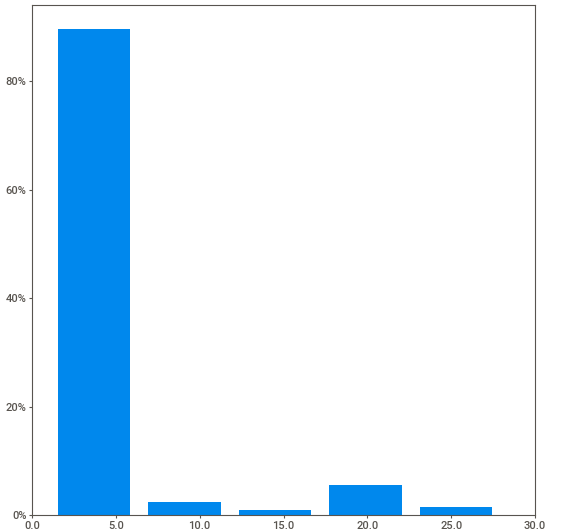
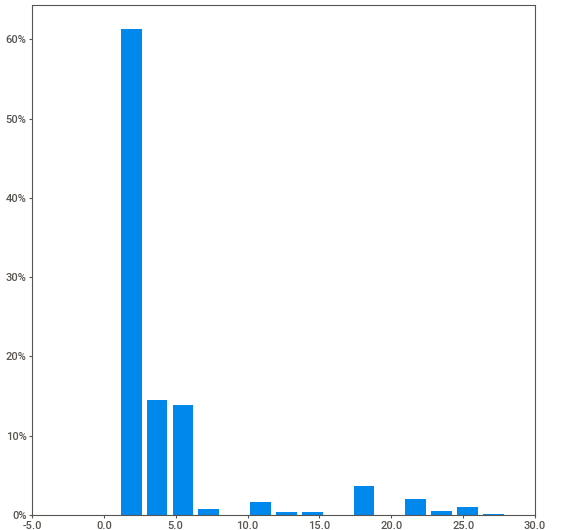
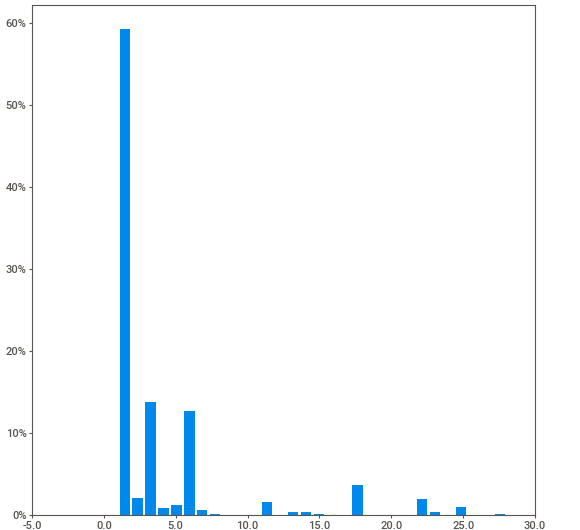
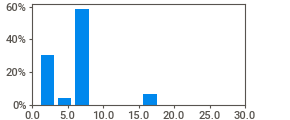
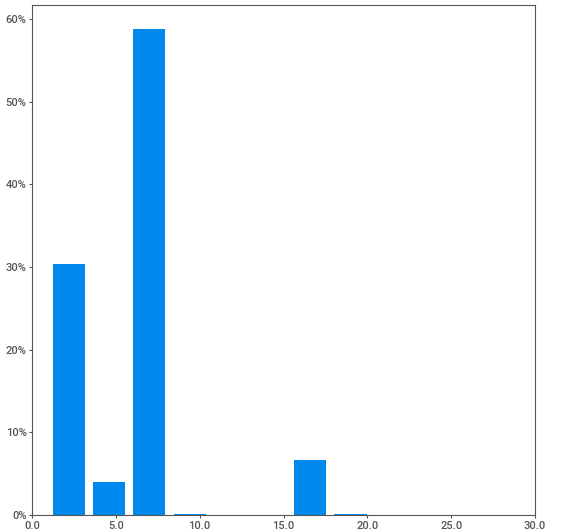
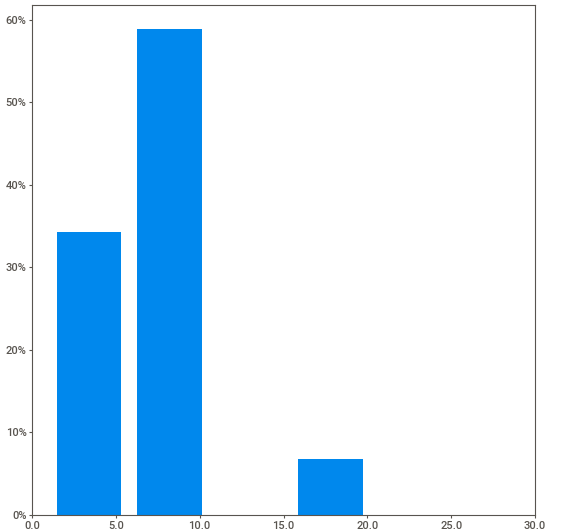
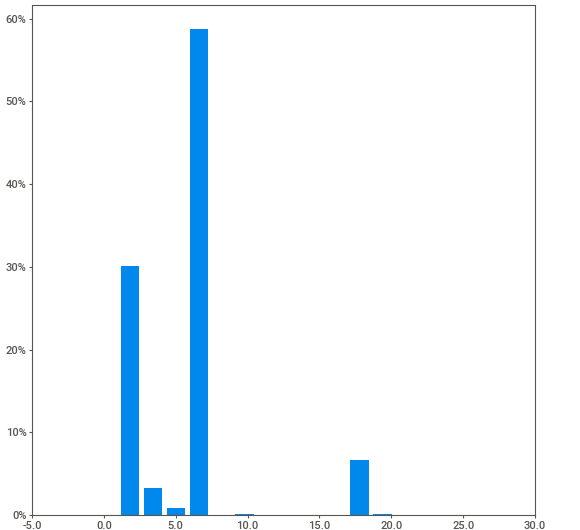
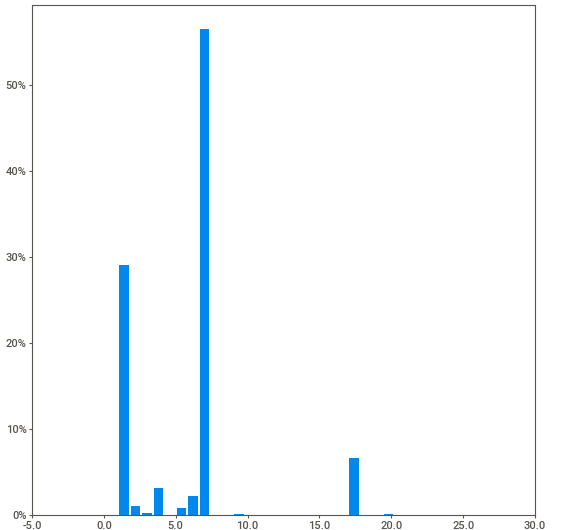
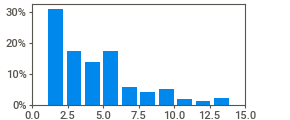
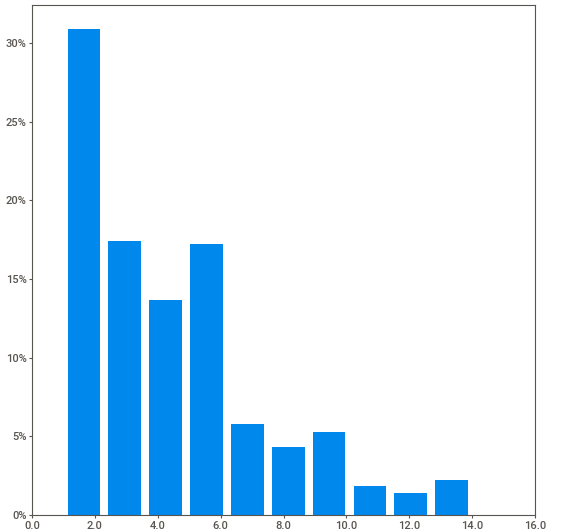
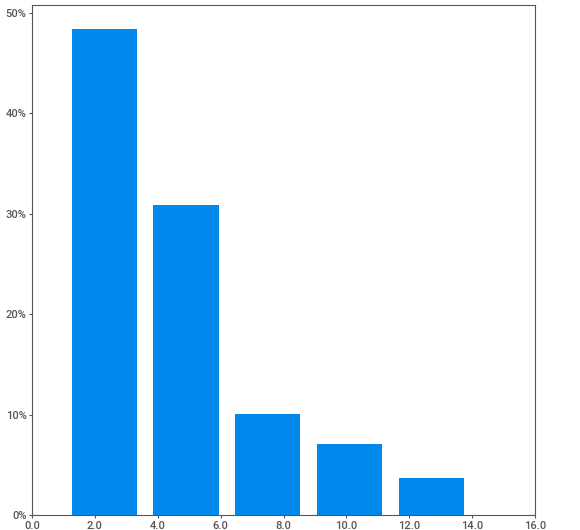
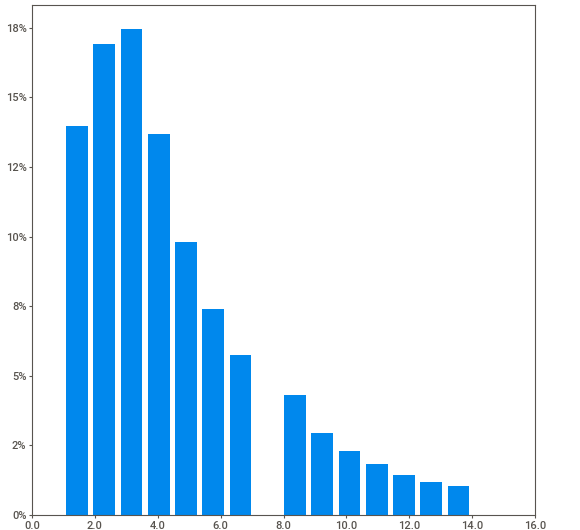
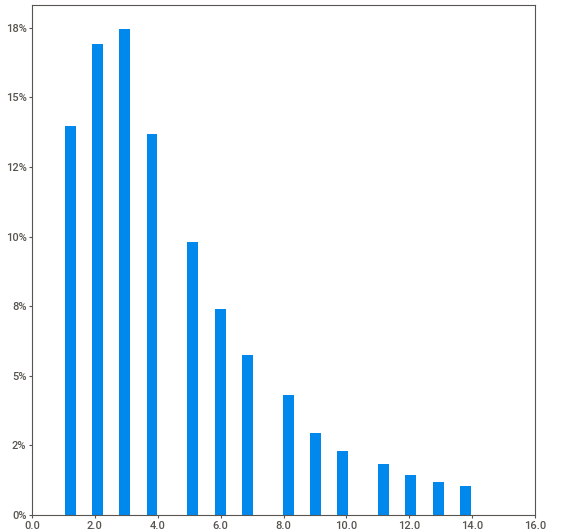
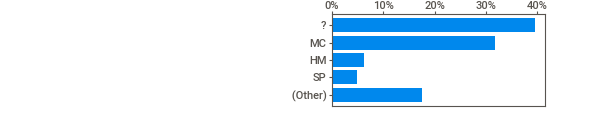
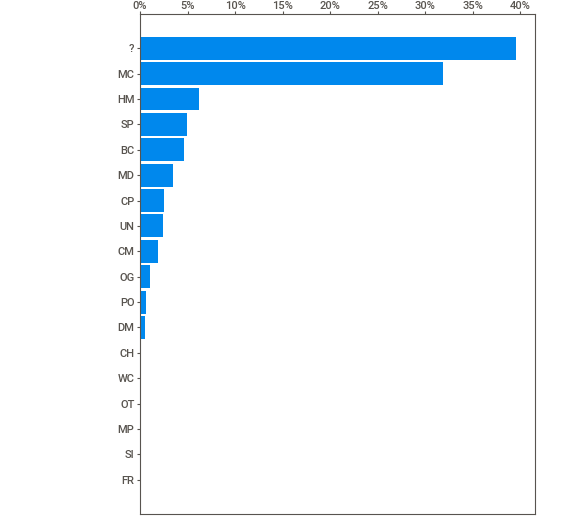
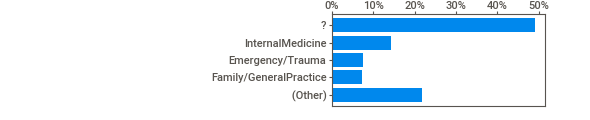
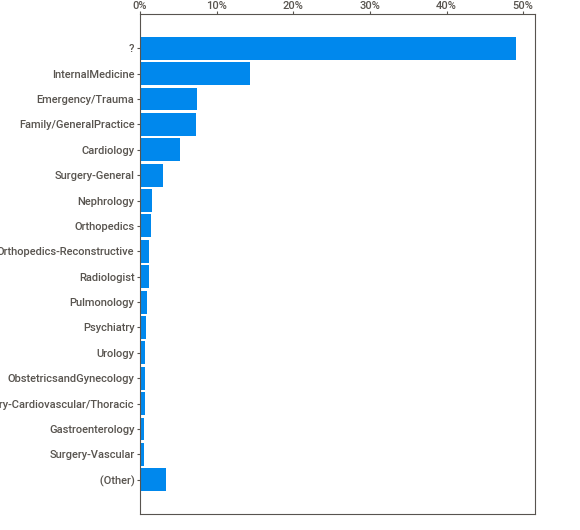
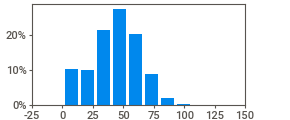
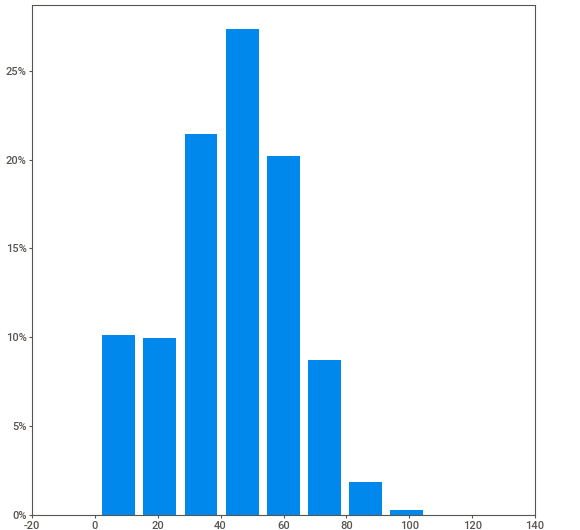
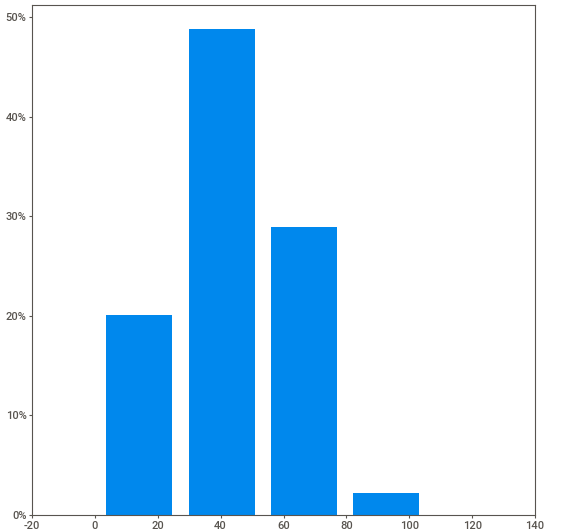
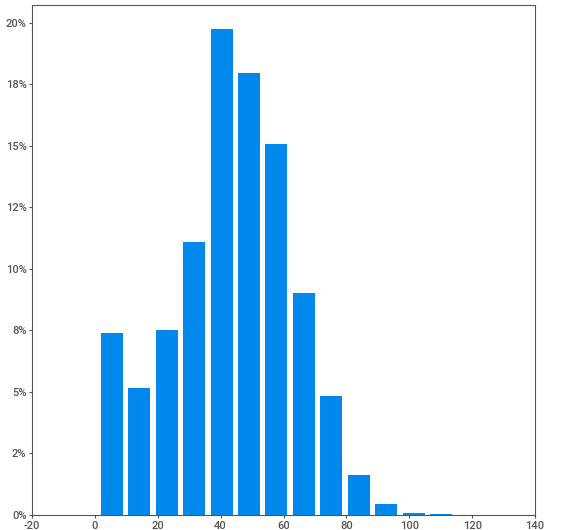
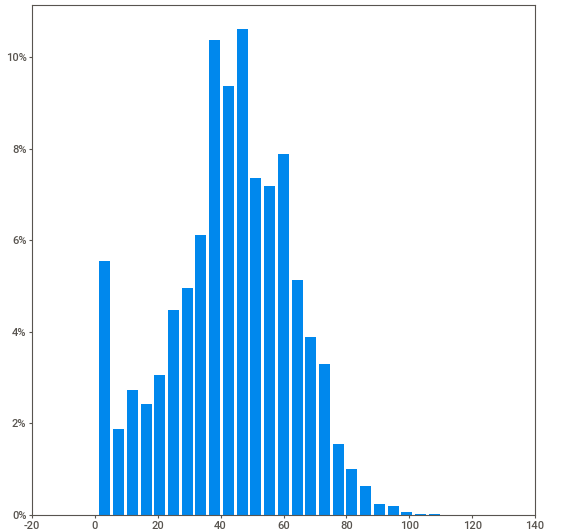
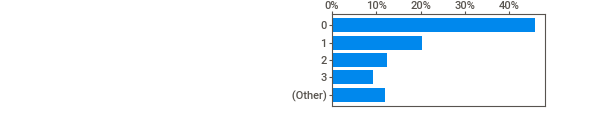
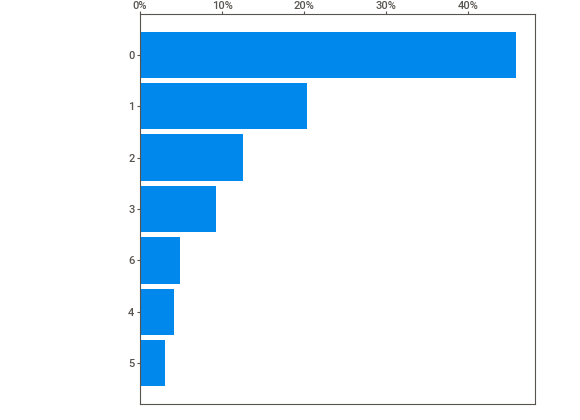
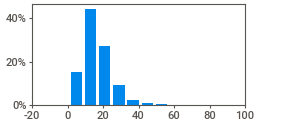
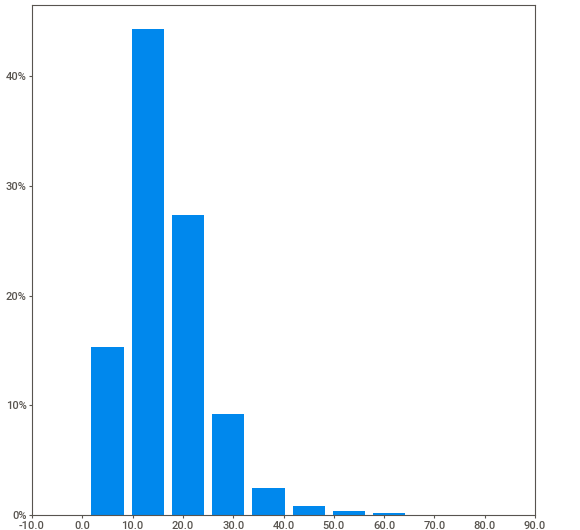
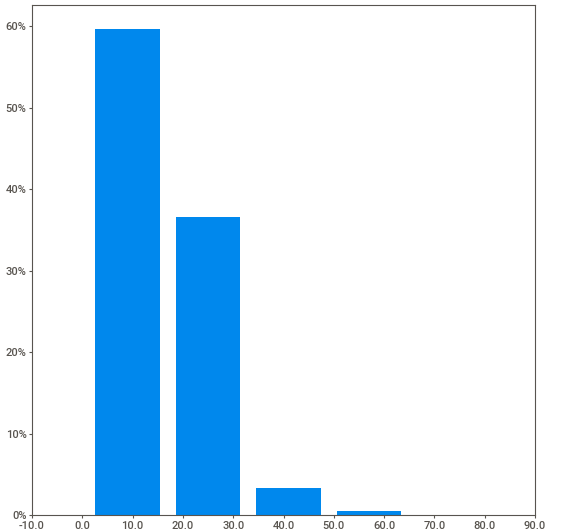
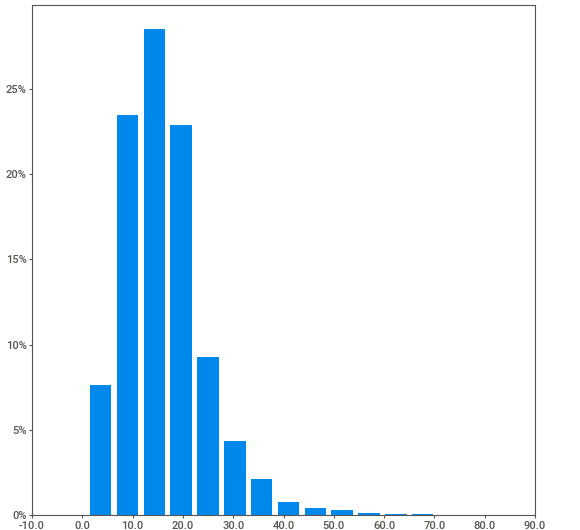
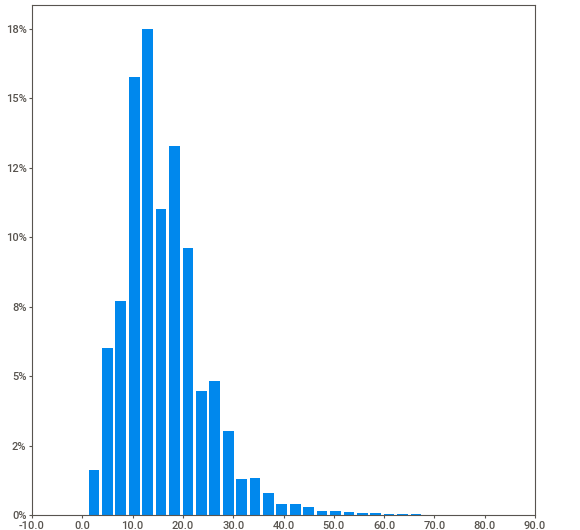
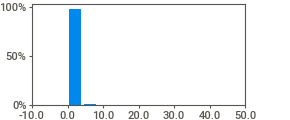
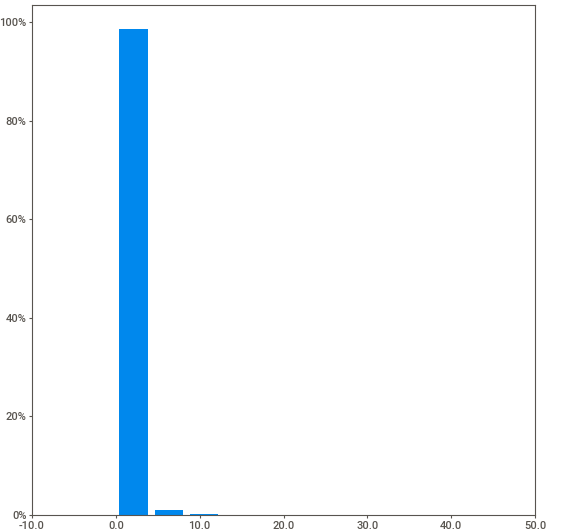
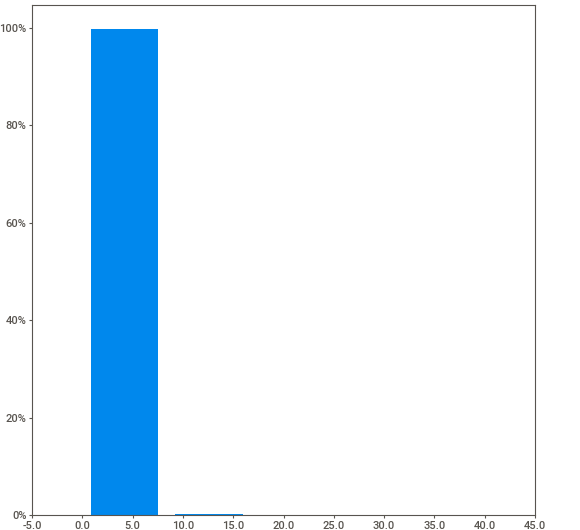
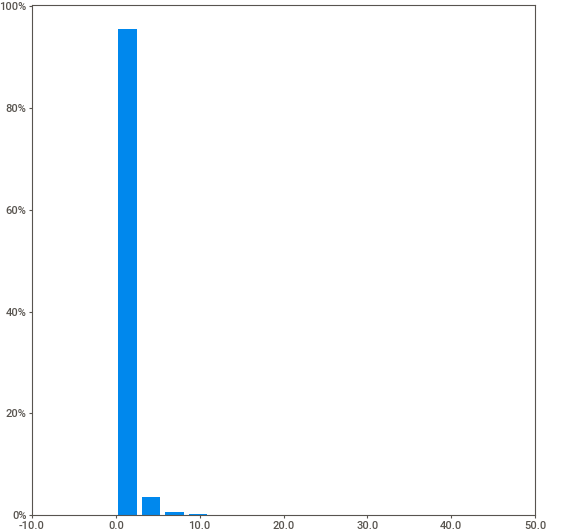
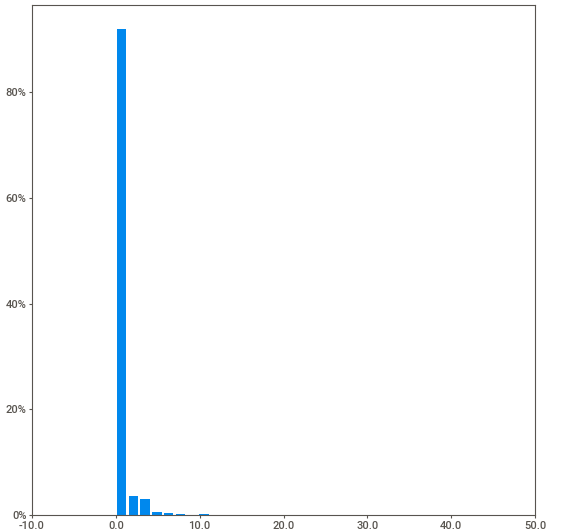
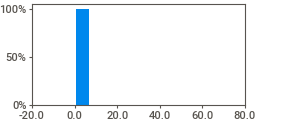
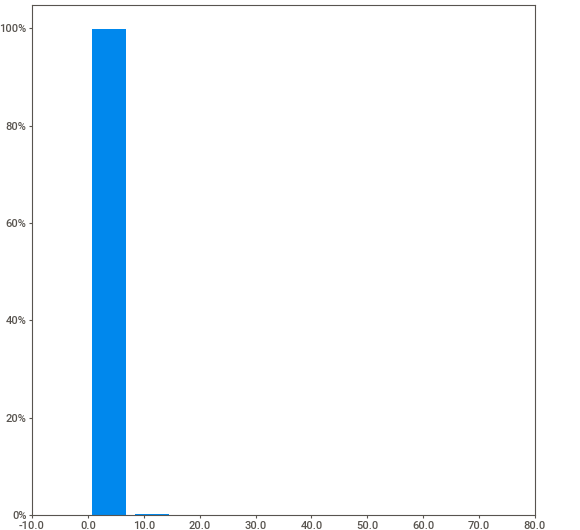
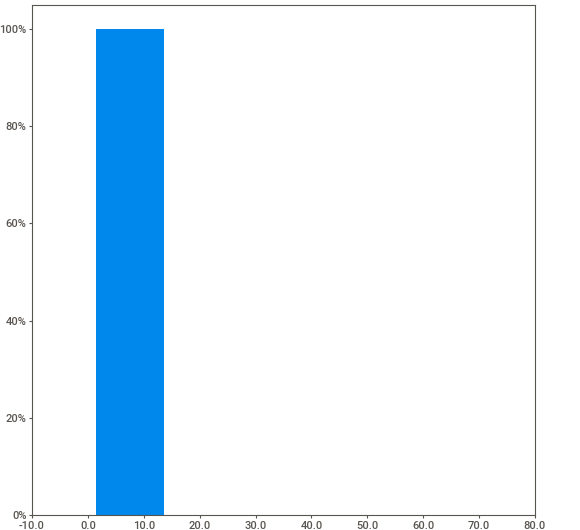
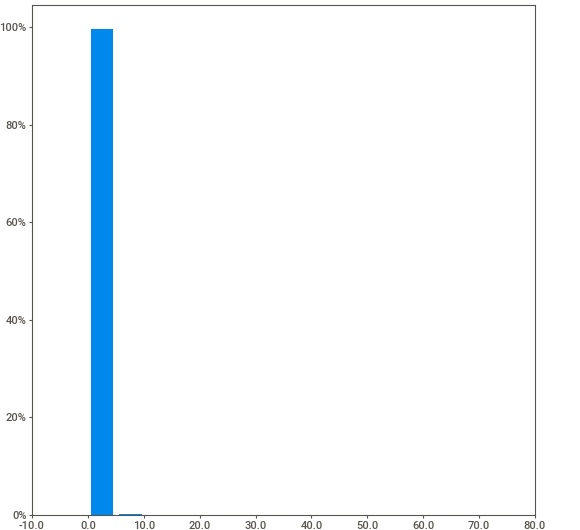
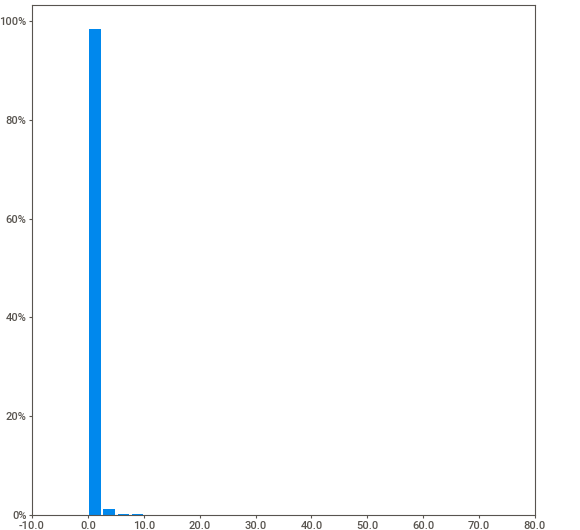
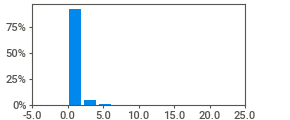
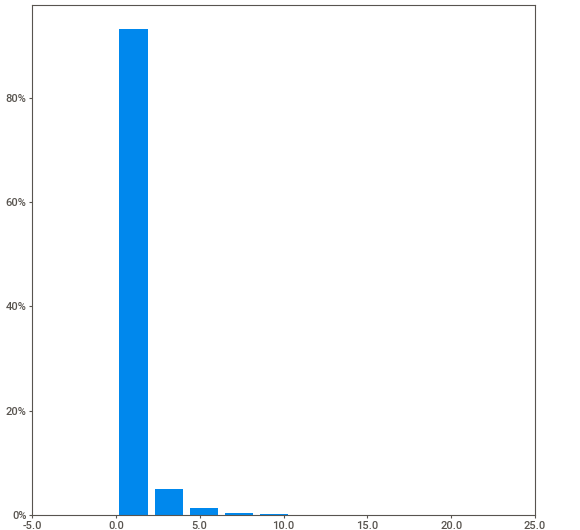
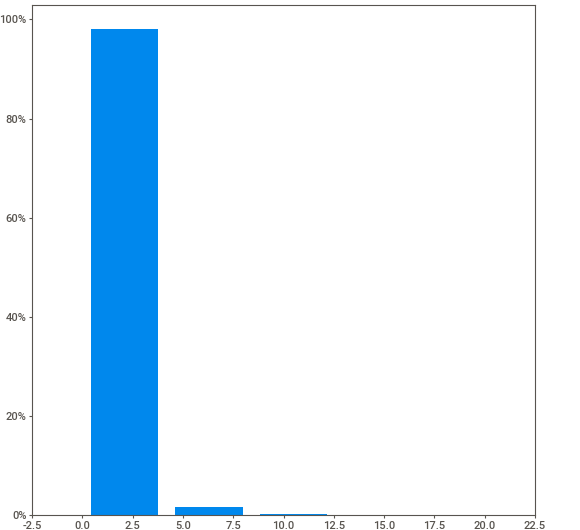
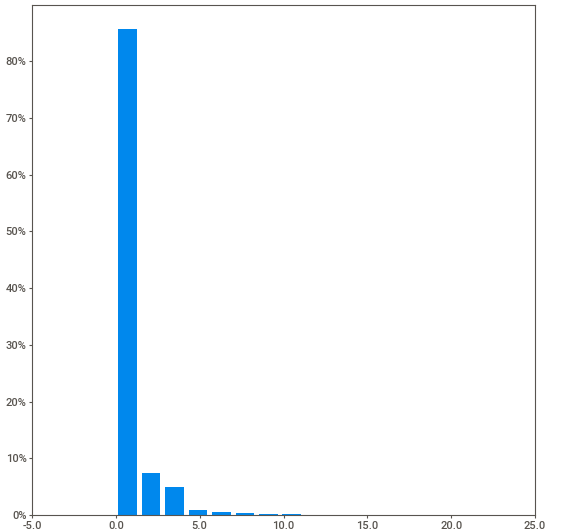
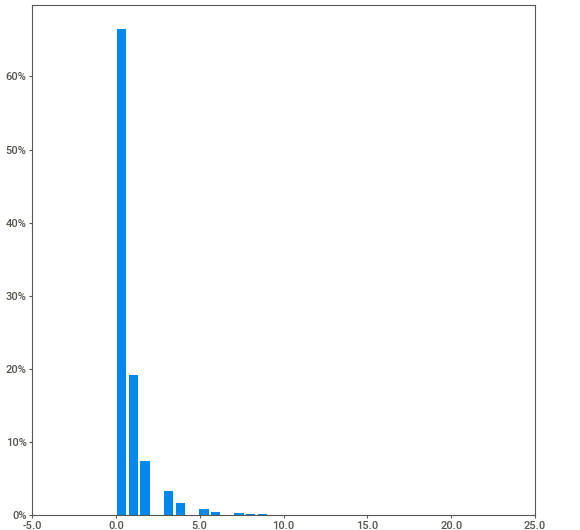
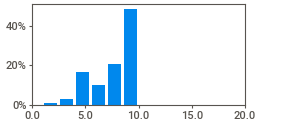
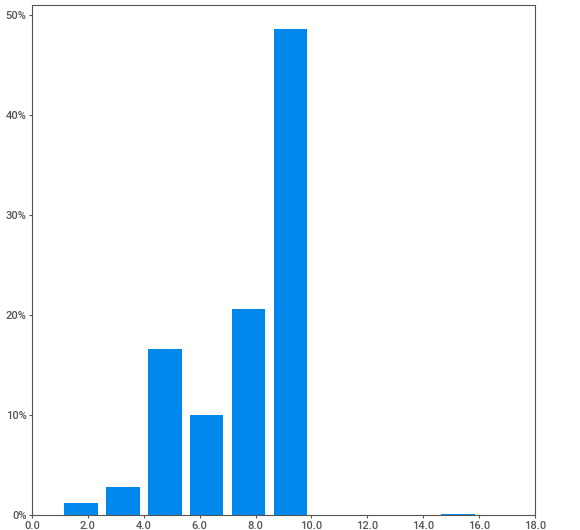
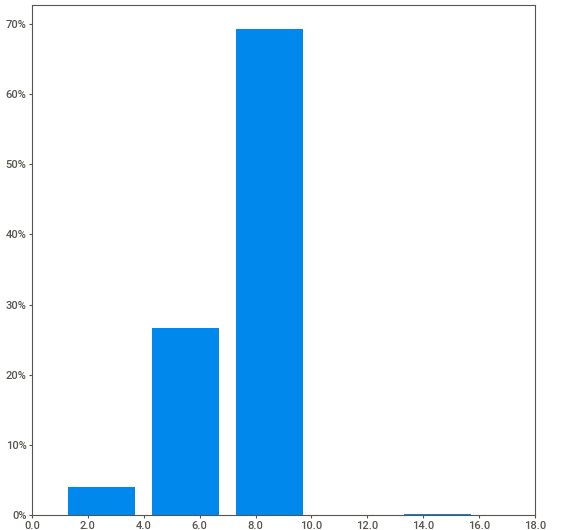
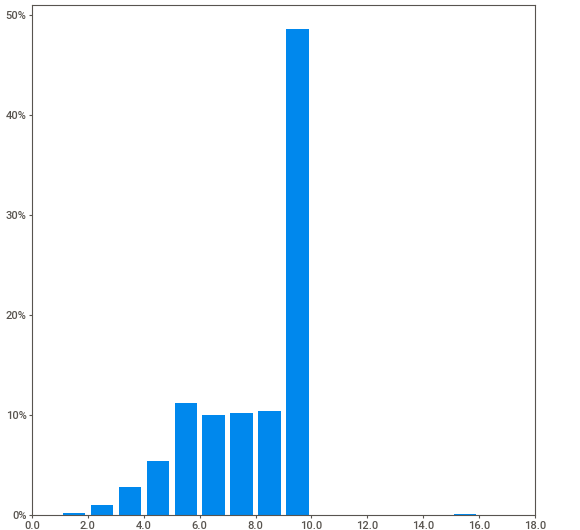
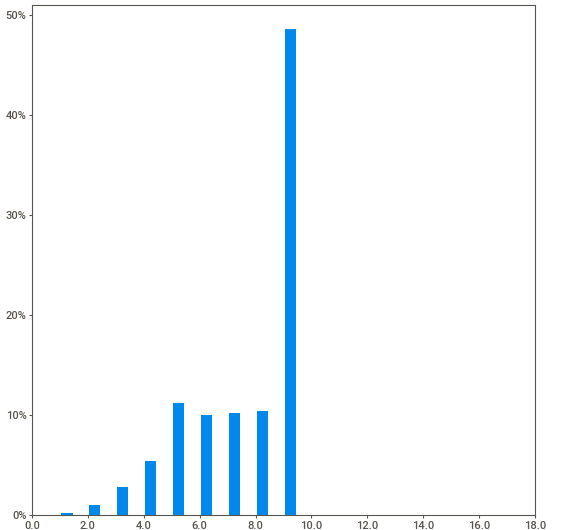
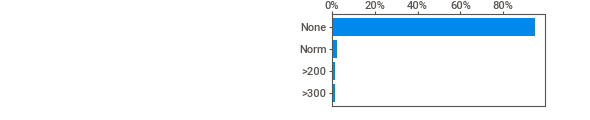
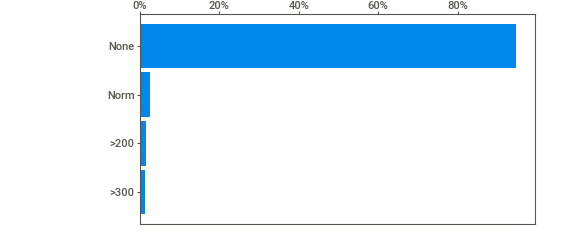
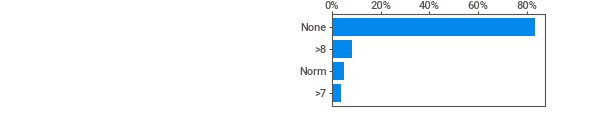
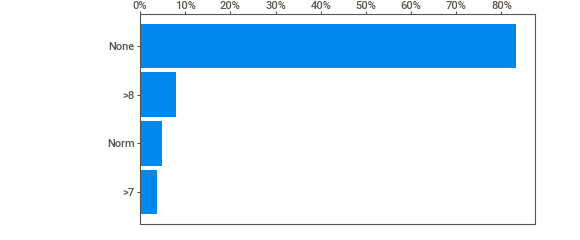
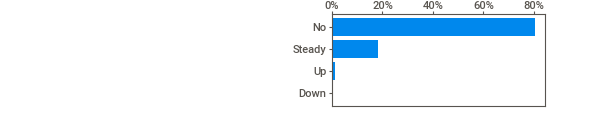
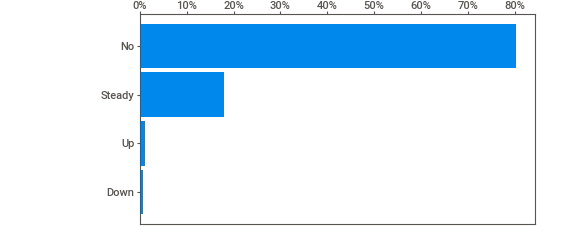
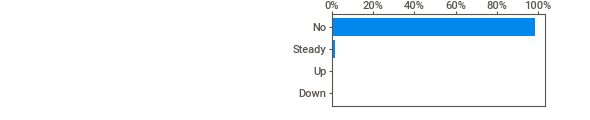
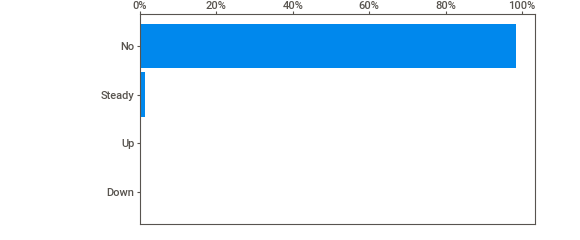
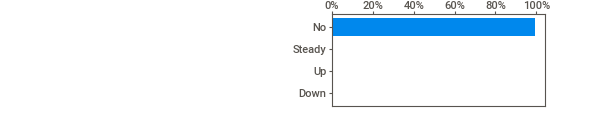
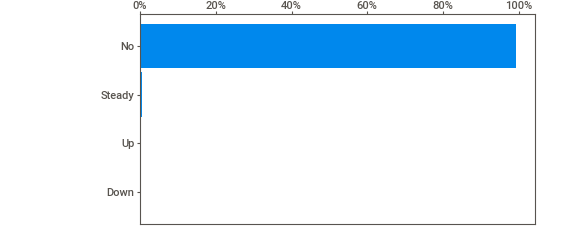
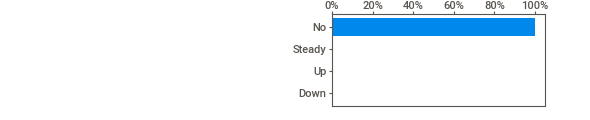
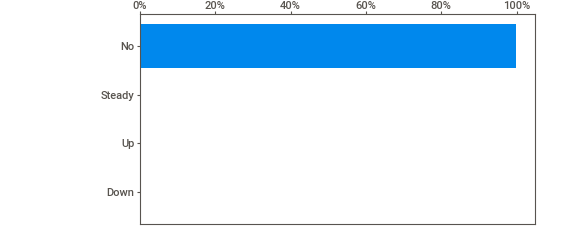
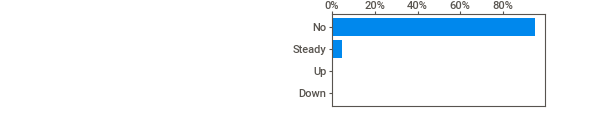
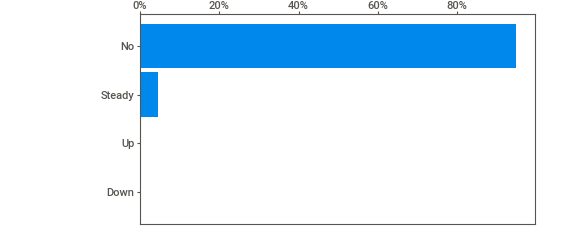
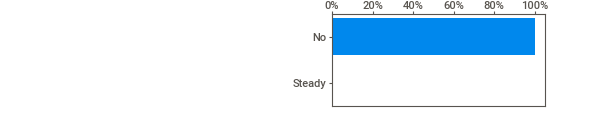
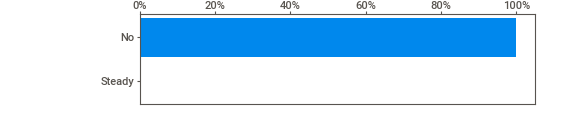
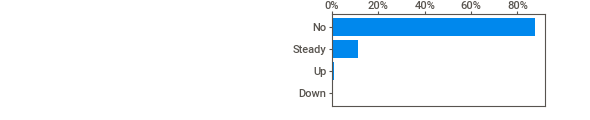
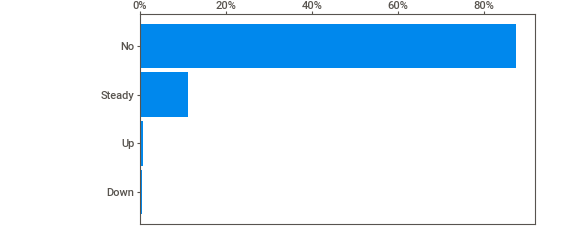
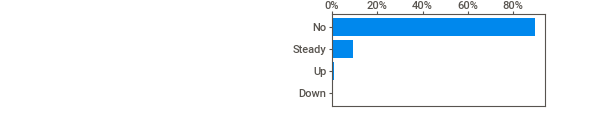
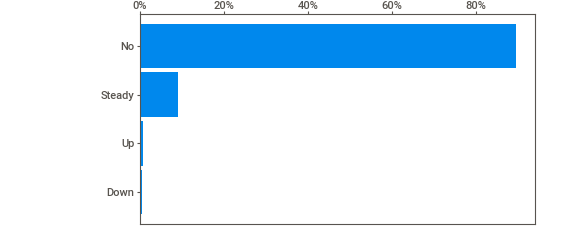
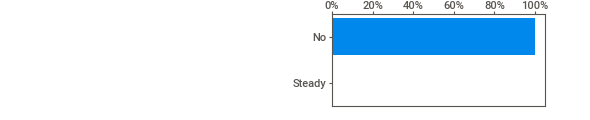
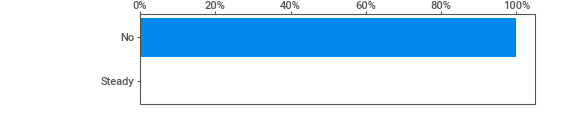
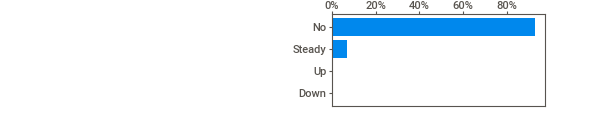
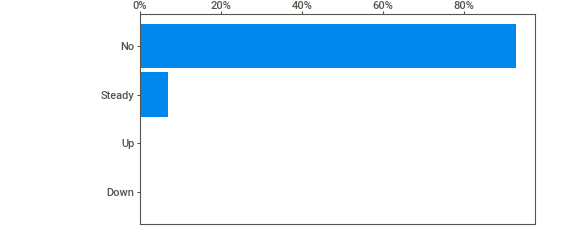
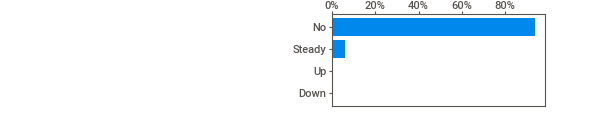
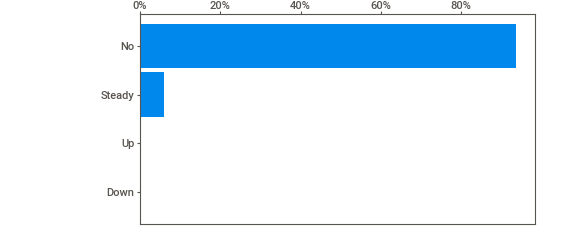
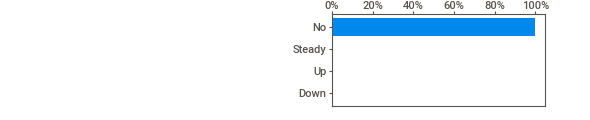
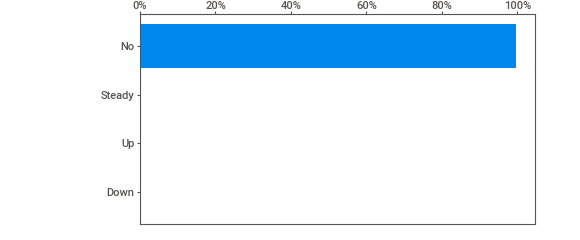
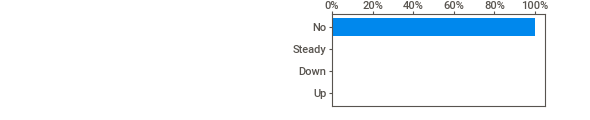
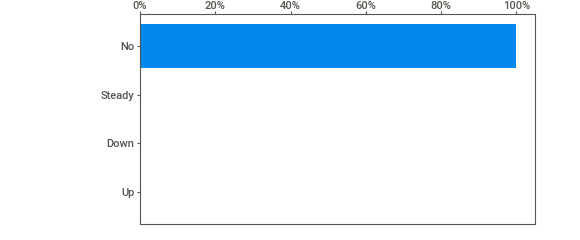
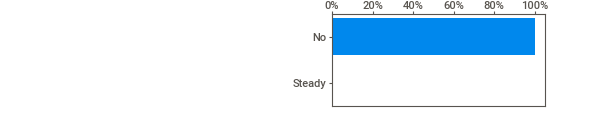
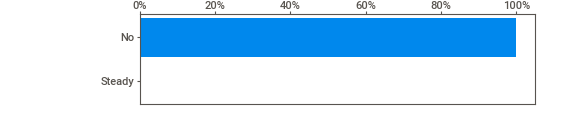
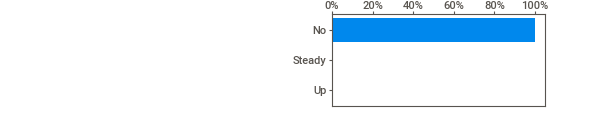
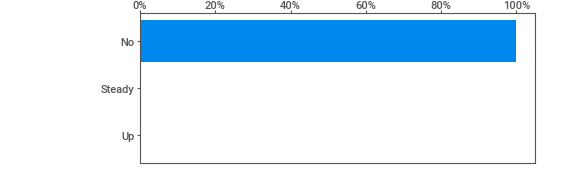
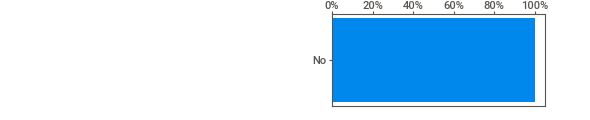
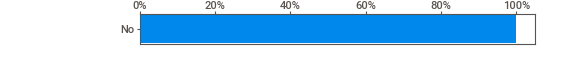
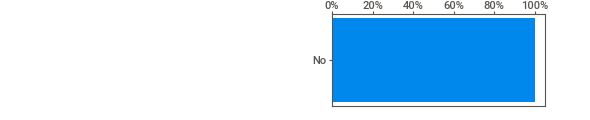
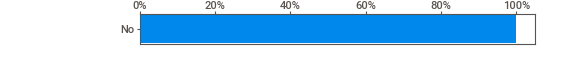
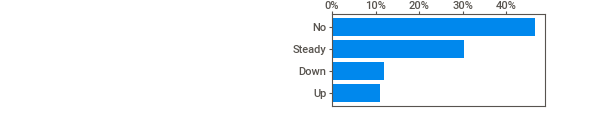
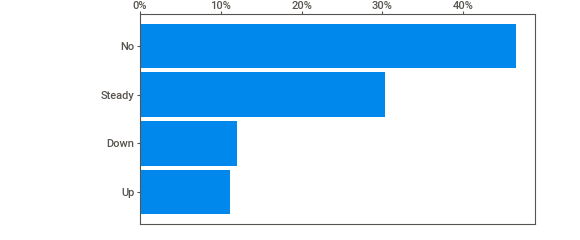
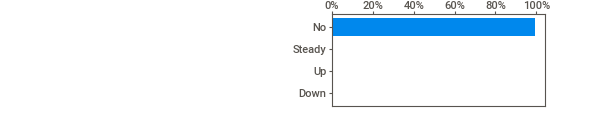
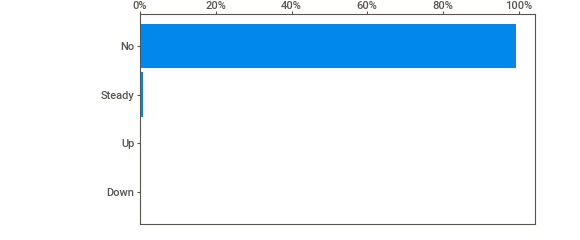
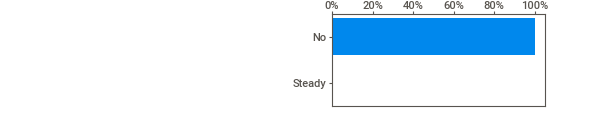
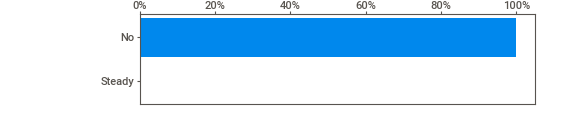
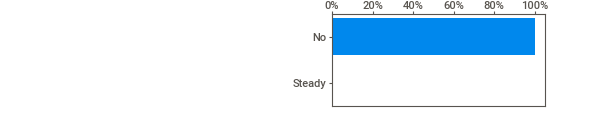
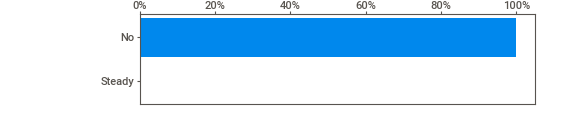
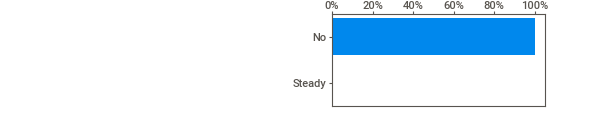
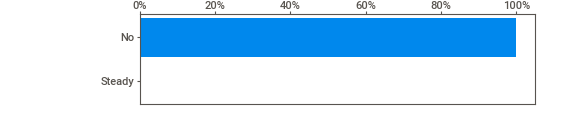
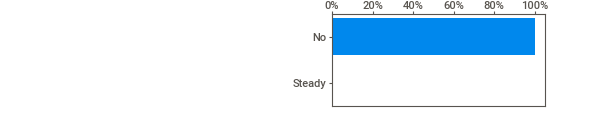
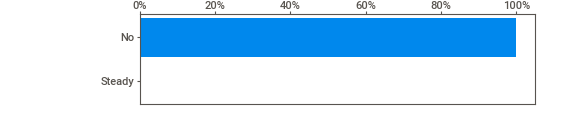
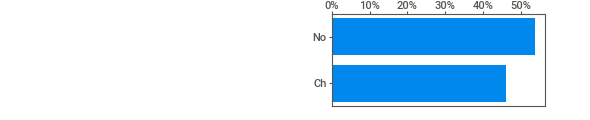
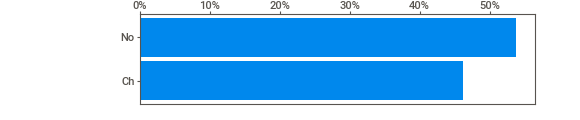
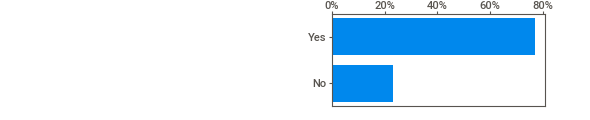
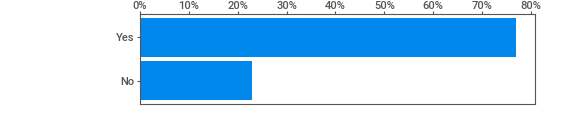
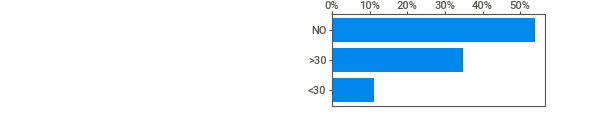
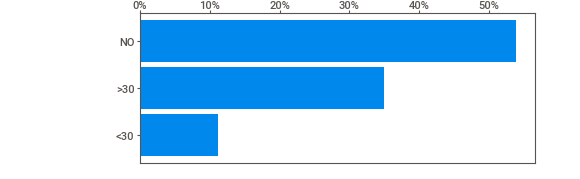
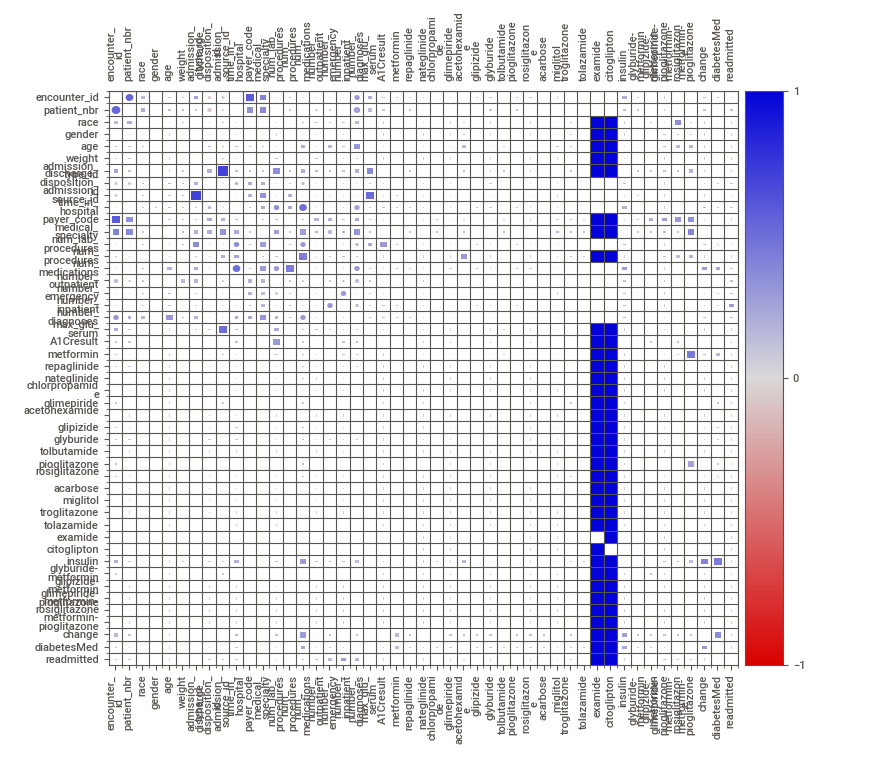
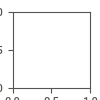

In [6]:
eda_report.show_notebook()

## Make sure you run this cell to see the report on the notebook. Also it can be checked it out on utils folder 'eda_report'

A priori conclusions based on the report: 

1. From the associations heatmap we can see a correlation between the days in hospital with number of procedure and mes, something that has sense and is expected.

2. Citopligmon and examide columns only contain one value each of them.
3. Proportion by gender is well balanced
4. A big proportion of the race data is about caucasians.
5. Examide and citoglipton only presents one value each.
6. There are a lot of differents values on discharge disposition, but most of them are discharged to home. It could be a noisy feature.
7. Admissions source could be re-mapped, so we can make a more usable feature
8. There is a direct correlation between time in hospital withe the number of medications and procedures.
9. There are several meds with no significant information, only contain one value.


*The report wes saved in utils folder as html file for further revision.*

### Initial data wrangling

There are several columns related to meds that doesn't contain relevant information, because only presents one value, or is higly imbalanced. For instance of a first iteration they can be discarded.

In [7]:
## Meds to discard
df = df.drop(columns=['metformin-pioglitazone','metformin-rosiglitazone','glimepiride-pioglitazone', 'glipizide-metformin','glyburide-metformin','citoglipton','examide','tolazamide','troglitazone','miglitol','acarbose','tolbutamide','acetohexamide','chlorpropamide','nateglinide','repaglinide'])

It's important to check the integrity of the information. In this case, missing values are represented as '?'. we'll count them to be aware of the quantity of missing values on each column, and after that we'll convert it to nan to keep a better control over the dataset.

In [8]:
## Checking for missing data on each column (In this case, they are represented as '?)
for column in df.columns:
    if df[column].dtype == object:
         print(column, df[column][df[column] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
glimepiride 0
glipizide 0
glyburide 0
pioglitazone 0
rosiglitazone 0
insulin 0
change 0
diabetesMed 0
readmitted 0


In [9]:
## Making some changes for futher manipulation
df = df.replace("?", np.nan)

### Data manipulation

###### 1. Drop of columns with no relevant information
The colums *payer_code*, *encounter_id* and *number_diagnoses* do not provide relevant information

In [10]:
df = df.drop(columns=['encounter_id','payer_code','number_diagnoses']) 

###### 2. Transform categories represented as intervals as the mean value beteween them.

In [11]:
##Treating age, weight and admissions with representative numbers intead of texts
interval_ages_to_replace = {"[70-80)":75, "[60-70)":65, "[50-60)":55, "[80-90)" : 85, "[40-50)":45, "[30-40)":35, 
                            "[90-100)":95, "[20-30)":25, "[10-20)":15, "[0-10)":5}

interval_weight_to_replace = {"[75-100)":85, "[50-75)":60, "[100-125)":110, "[125-150)":135, "[25-50)":35,
                             "[0-25)":10, "[150-175)":160, "[175-200)":185, ">200":205}

df['age'] = df['age'].replace(interval_ages_to_replace)
df["weight"] = df["weight"].replace(interval_weight_to_replace)

In [12]:
## Urgent could be mapped as emergency, and 3 of the id's can be mapped as nan.
admissions = {1.0:"Emergency",
          2.0:"Emergency",
          3.0:"Elective",
          4.0:"New Born",
          5.0:np.nan,
          6.0:np.nan,
          7.0:"Trauma Center",
          8.0:np.nan}

df['admission_type_id'] = df['admission_type_id'].replace(admissions)

### Statistical analysis with target variable

For a first iteration the target variable could be re-mapped as binary variable, where we can define just if a patient will be re-admitted eventually, or not at all.

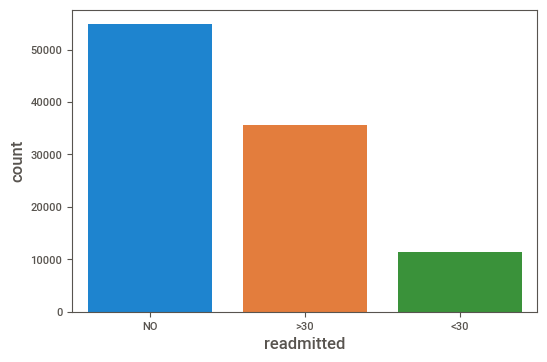

In [13]:
sns.countplot(x='readmitted', data=df)
plt.show()

In [14]:
## Re-mapping values
df = df.replace({"NO":0, "<30":1, ">30":1})

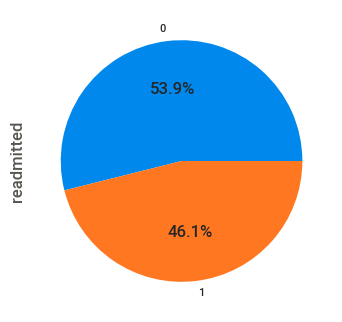

In [15]:
df.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.show()

In [16]:
df.readmitted.value_counts()

0    54864
1    46902
Name: readmitted, dtype: int64

So in this way we have a balanced dataset. It could be even improved with data augmentation and compare how is the performance of predictive models with augemented dataset vs original balanced dataset.

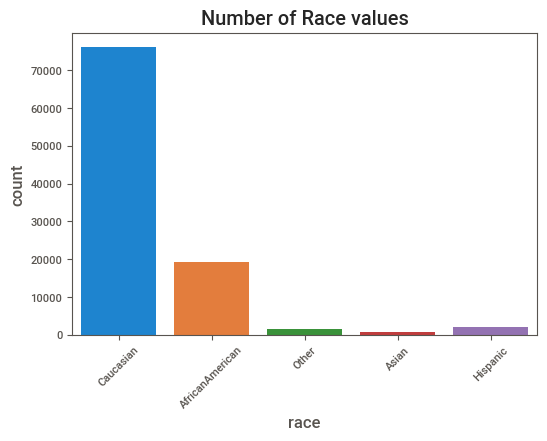

In [17]:
sns.countplot(x=df.race, data = df)
plt.xticks(rotation=45)
plt.title("Number of Race values")
plt.show()

In [18]:
print(df.race.value_counts(normalize = True)*100)

Caucasian          76.486788
AfricanAmerican    19.307891
Hispanic            2.047380
Other               1.513674
Asian               0.644266
Name: race, dtype: float64


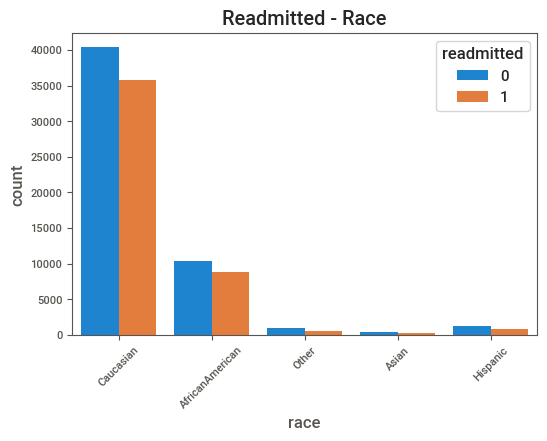

In [19]:
sns.countplot(x="race", hue= "readmitted", data = df)
plt.title("Readmitted - Race")
plt.xticks(rotation=45)
plt.show()

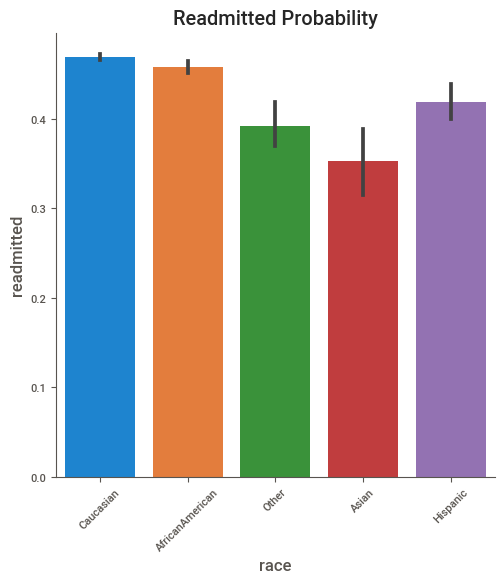

In [20]:
sns.catplot(x = "race", y = "readmitted", data = df, kind = "bar", height= 5)
plt.title("Readmitted Probability")
plt.xticks(rotation=45)
plt.show()

From the images above we have some intuition about how could be possibly related the race with the readmission rate. The images suggest that if you are asian of belongs to other race you could have less probability of needing a further readmission.

we want to deepen on this making a Montecarlo simulation to corroborate this hypothesis.

### Montecarlo simulation to check relation between races and readmission

***Null hypothesis - h0:*** we'll use as null hypothesis that every race would have similar numbers to the global readmission rate. It means that the race doesn't affect the probability of readmission. 

In [21]:
np.mean(df['readmitted'])

0.4608808442898414

So we'll simulate a lot of random experiments using the supposition (0.45) and check how is the behaviour of these. Expected: normal distribution around 0.45. Each experiment will have a size of 1000, that is the aproximate number of patients with minority races (Asians, hispanics, afroamericans, others)

In [22]:
h0_prob = 0.45 # Our hypothesis of readmission
simulate = lambda p = h0_prob : (np.random.random(size=1000)<p).astype(int)

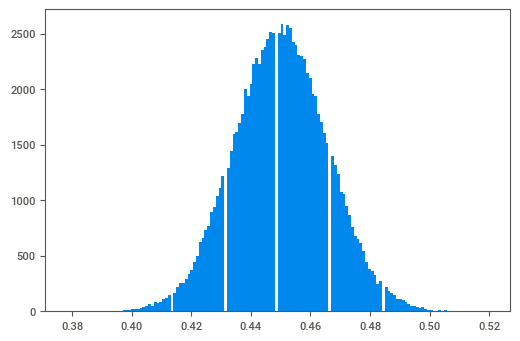

In [23]:
simulated_exps = [np.mean(simulate()) for _ in range(100000)]
plt.hist(simulated_exps, bins=150);
plt.show()

Now we'll collect the observations of each race, and we'll check if these observations fits into the acceptance band of the experiment. we'll use the traditional band of acceptance of 2.5% -> 97.6%

In [24]:
## Observations: readmission by race
asians = np.mean(df[df['race'] == 'Asian']['readmitted'])
hispanic = np.mean(df[df['race'] ==' Hispanic']['readmitted'])
caucasian = np.mean(df[df['race'] == 'Caucasian']['readmitted'])
afro_american = np.mean(df[df['race'] == 'AfricanAmerican']['readmitted'])
other = np.mean(df[df['race'] == 'Other']['readmitted'])

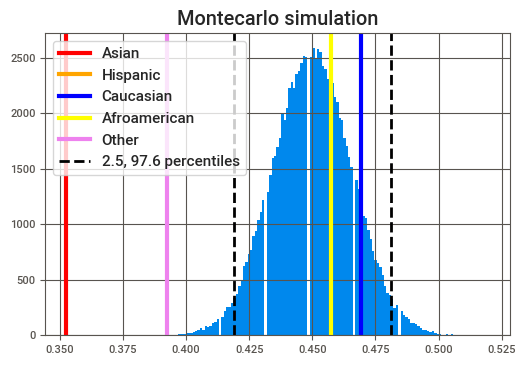

In [25]:
plt.hist(simulated_exps, bins=150)
lw = 3
t0, t1 = np.percentile(simulated_exps, [2.5, 97.5])
plt.axvline(asians, color="red", label="Asian", lw=lw)
plt.axvline(hispanic, color="orange", label="Hispanic", lw=lw)
plt.axvline(caucasian, color="blue", label="Caucasian", lw=lw)
plt.axvline(afro_american, color="yellow", label="Afroamerican", lw=lw)
plt.axvline(other, color="violet", label="Other", lw=lw)



plt.axvline(t0, color="black", lw=2, ls="--", label="2.5, 97.6 percentiles")
plt.axvline(t1, color="black", lw=2, ls="--")
plt.legend() 
plt.grid()
plt.title("Montecarlo simulation")
plt.show()

So the asians and the other races are out of the acceptance band. That means that we can reject the null hypothesis for these races. So, for asians and other races there is a lower probability of being readmitted. 

For us it has cultural sense: asians are a very disciplined culture. They should have better control of their meds and the recommendations of the doctors. Also the eating habits of asians are well known for being very healthy, and the eating habits is a very important factor regarding to diabetes issues.

It's important to be aware of this relation of the races with readmission in order to keep this feature at the time of making predictive models, or manipulate the race column.

We'll continue with the analysis of other features.

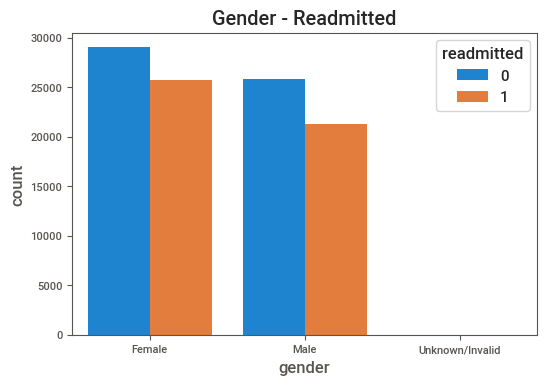

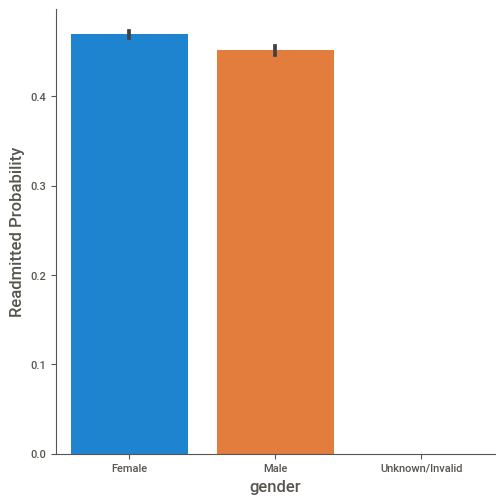

In [26]:
sns.countplot(x = "gender", hue = "readmitted", data = df)
plt.title("Gender - Readmitted")
plt.show()

g = sns.catplot(x = "gender",y = "readmitted", 
                data = df, kind = "bar", height= 5)
g.set_ylabels("Readmitted Probability")
plt.show()

There is nothing significant to note between the gender and readmissions.

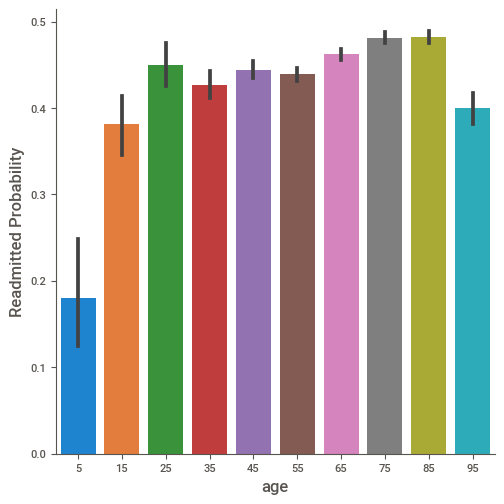

In [27]:
g = sns.catplot(x = "age", y = "readmitted", data = df, kind = "bar", height = 5)
g.set_ylabels("Readmitted Probability")
plt.show()

The range [0,20) presents lower rates of readmission, it could be explainable having in mind that the young people is healthier. All the ranges after the [0, 20) range presents similar rates of readmissions. 

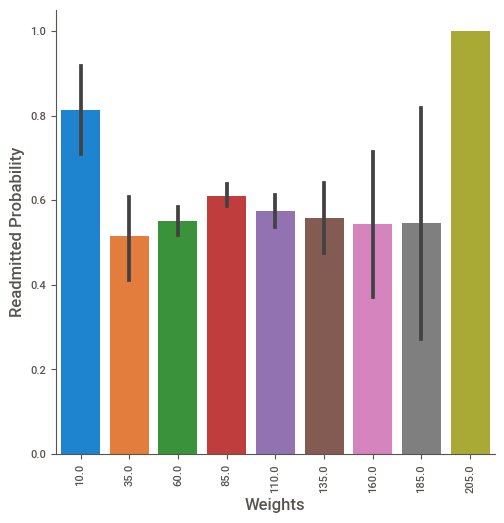

In [28]:
g = sns.catplot(x = "weight", y = "readmitted", kind = "bar", data = df, height = 5)
g.set_xticklabels(rotation = 90)
g.set_ylabels("Readmitted Probability")
g.set_xlabels("Weights")
plt.show()

In [29]:
print(df.weight.value_counts())

85.0     1336
60.0      897
110.0     625
135.0     145
35.0       97
10.0       48
160.0      35
185.0      11
205.0       3
Name: weight, dtype: int64


It's important to be aware that newborns with very low weight [0, 10) have a higher chance of readmission.

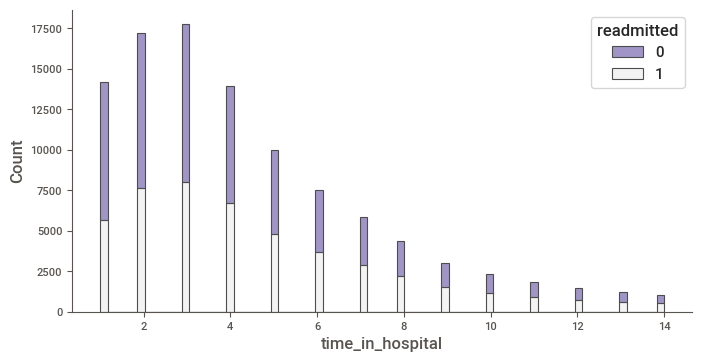

In [30]:
f, ax = plt.subplots(figsize=(8, 4))
sns.despine(f)

sns.histplot(
    df,
    x="time_in_hospital", hue="readmitted",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.8
)

plt.show()

Time in hospital doesn't have a special relation with readmission. We can observe the same proportions throughout the different amount of days in hospital.

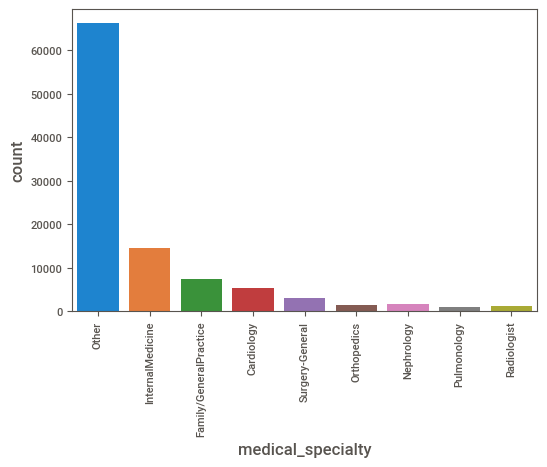

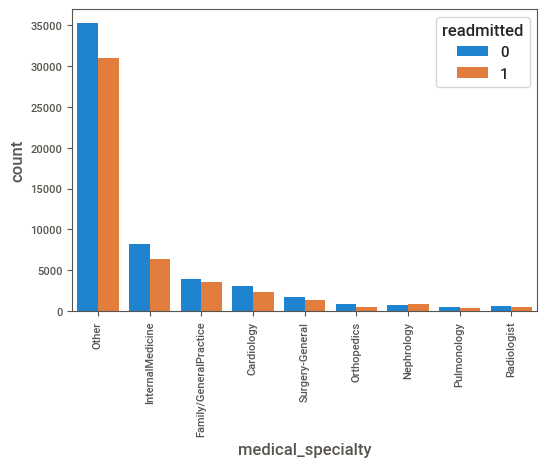

In [31]:
top=['InternalMedicine','Family/GeneralPractice','Cardiology','Surgery-General',
        "Nephrology","Orthopedics","Radiologist","Pulmonology"]

df.loc[~df['medical_specialty'].isin(top),'medical_specialty'] = 'Other'



sns.countplot(x = "medical_specialty", data = df)
plt.xticks(rotation = 90)
plt.show()

sns.countplot(x = "medical_specialty",hue = "readmitted", data = df)
plt.xticks(rotation = 90)
plt.show()

Patients referred by nephrology has slightly higher chance of needing a readmission.

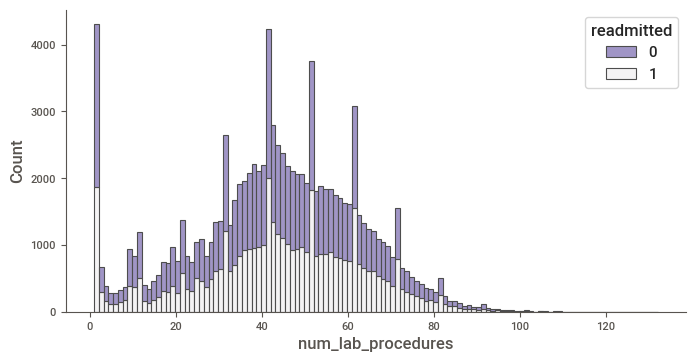

In [32]:
f, ax = plt.subplots(figsize=(8, 4))
sns.despine(f)

sns.histplot(
    df,
    x="num_lab_procedures", hue="readmitted",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.8
)
plt.show()

In [33]:
print(df.num_procedures.value_counts(normalize=True)*100)

0    45.842423
1    20.382053
2    12.496315
3     9.279131
6     4.868031
4     4.107462
5     3.024586
Name: num_procedures, dtype: float64


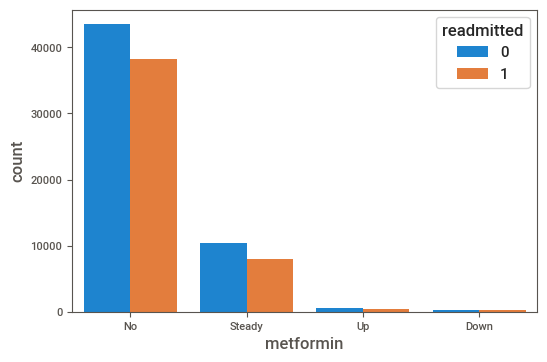

METFORMIN
No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64


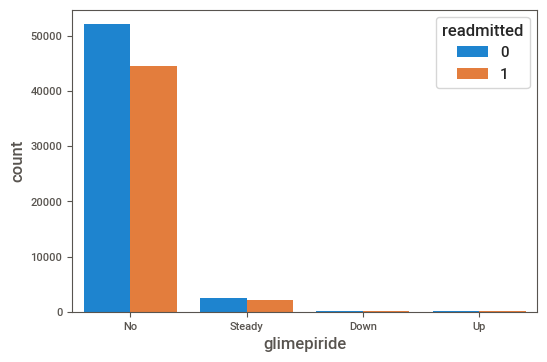

GLIMEPIRIDE
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64


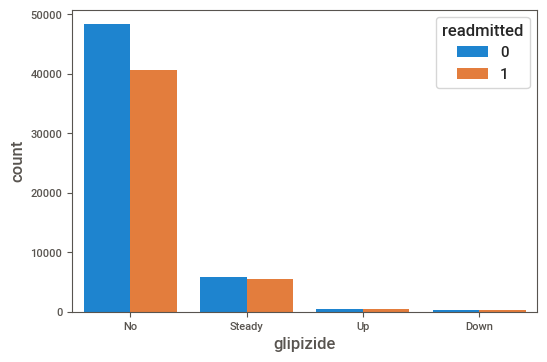

GLIPIZIDE
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64


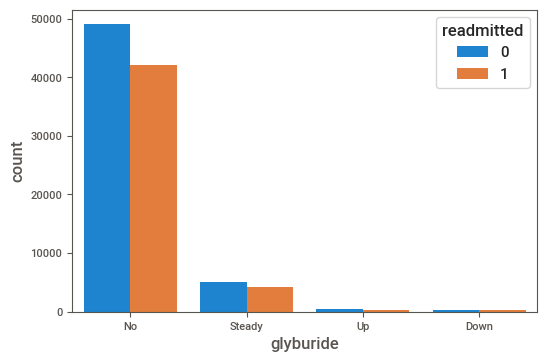

GLYBURIDE
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64


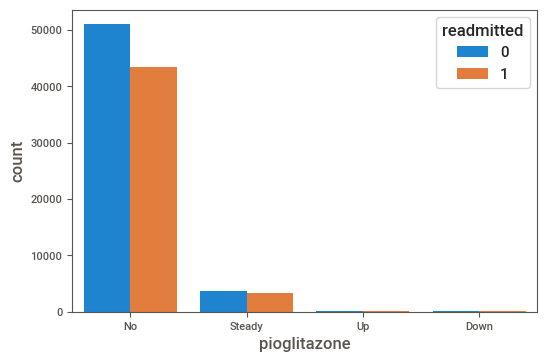

PIOGLITAZONE
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64


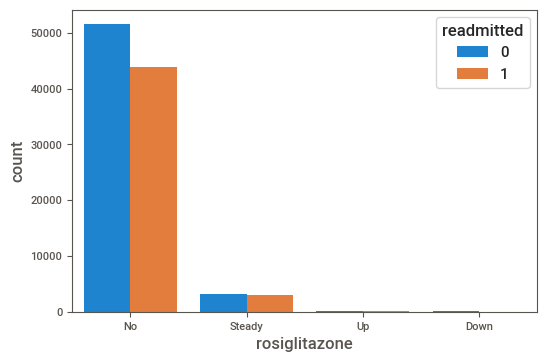

ROSIGLITAZONE
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dtype: int64


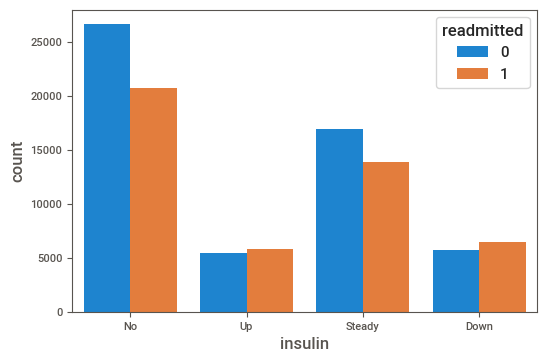

INSULIN
No        47383
Steady    30849
Down      12218
Up        11316
Name: insulin, dtype: int64


In [34]:
meds = ['metformin', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'insulin']

for med in meds:
    sns.countplot(x = med, 
                  hue = "readmitted",
                  data = df)
    plt.show()
    print(med.upper())
    print(df[f"{med}"].value_counts())

Nothing important to point on meds regarding to readmission.

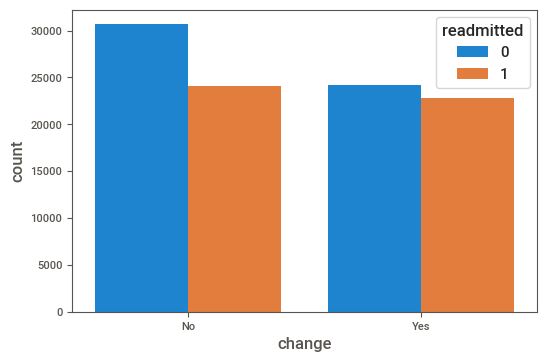

In [35]:
df.change = df.change.replace("Ch","Yes")
sns.countplot(x = "change", hue = "readmitted", data = df)
plt.show()

Patients with changes on their meds has slightly higher chance of needing a further readmission.

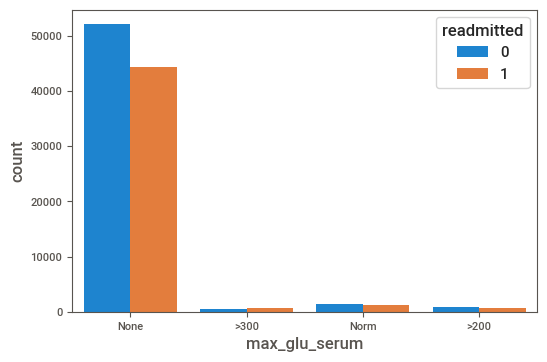

In [36]:
sns.countplot(x = "max_glu_serum",hue = "readmitted", data = df)
plt.show()

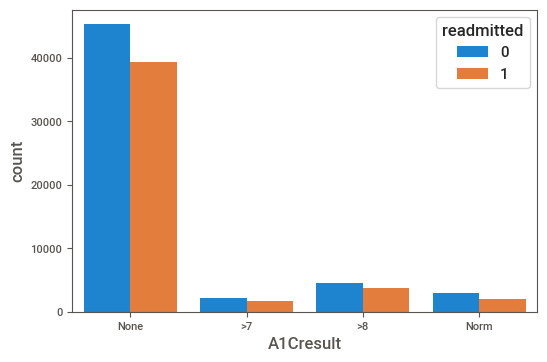

In [37]:
sns.countplot(x = "A1Cresult",hue = "readmitted", data = df)
plt.show()

#### Creating new features that could be useful

We'll create a couple of new features based on the request, per patient, of hospital services. 1 -> On 1 year period.  2 -> On 10 years period. For the 1 year period I'll sum the features 'number_outpatient', 'number_emergency' and 'number_inpatient'. Those are features related to hospital services requesting on the last year.

For the 10 years period we'll check how many appeareances each patient has on the dataset. I expect that these new features have certain positive correlation with readmissions. 

In [38]:
df['requests_1'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


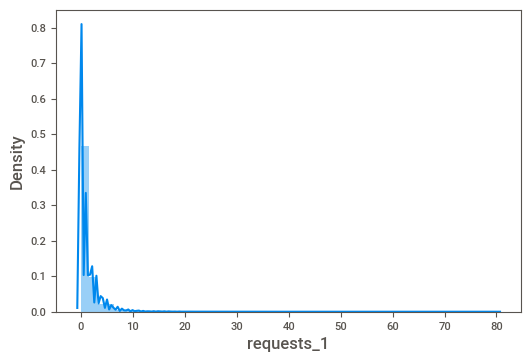

In [39]:
sns.distplot(df['requests_1'])
plt.show()

In [40]:
requests_10 = df[df['patient_nbr'].duplicated()].patient_nbr.value_counts()
df['requests_10'] = df['patient_nbr'].apply(lambda x: requests_10[x] if x in requests_10 else 0)

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


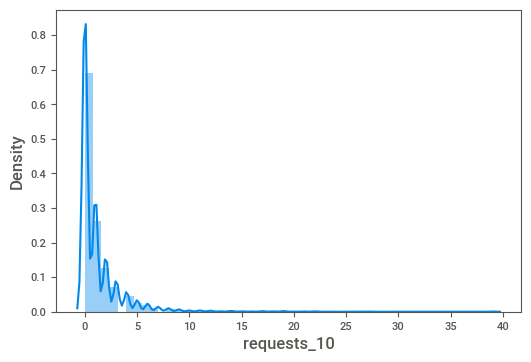

In [41]:
sns.distplot(df['requests_10'])
plt.show()

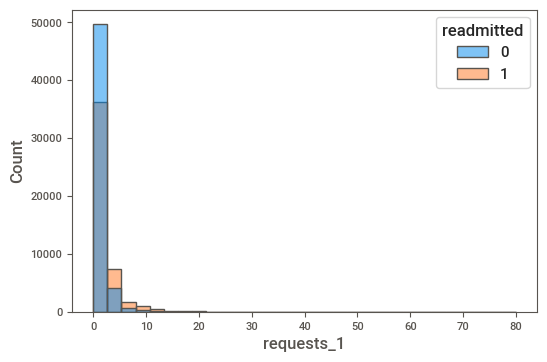

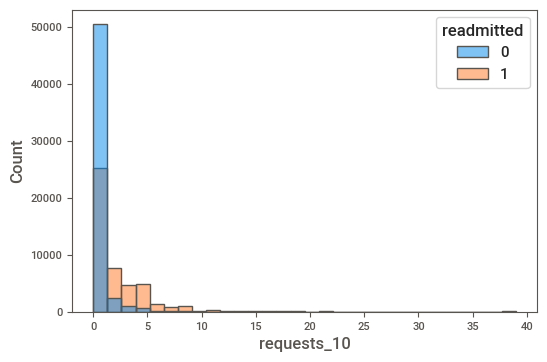

In [42]:
sns.histplot(data = df, x='requests_1', hue='readmitted', bins=30)
plt.show()
sns.histplot(data = df, x='requests_10', hue='readmitted', bins=30)
plt.show()

As we see on the images, there is present a direct relation between readmissions and requesting hospital services both in 1 year period as in 10 years period, so it's important to include these features that I've created at the time of making predictive models.

In [43]:
## Last check
df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032,77391171,85504905,77586282,49726791,86328819,92519352,108662661,107389323,69422211,22864131,21239181,63000108,107400762,62718876,21861756,40523301,115196778,41606064,18196434,56480238,96664626,80845353,114715242,3327282,63023292,98427861,112002975,101002446,104672268,80588529,99715041,96435585,66274866,80177094,106936875,86240259,51838164,90097839,34997814
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,AfricanAmerican,NaN,NaN,NaN,AfricanAmerican,Caucasian,AfricanAmerican,Other,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,Female,Male,Female,Male,Female,Male,Male,Female,Male,Male,Female,Male,Female,Female,Female,Female,Male,Female,Male,Female,Female,Male,Female,Male,Female,Female,Female,Female,Male,Male,Female,Male,Female,Male,Female,Female,Female,Male,Male,Male
age,5,15,25,35,45,55,65,75,85,95,45,65,45,85,65,65,55,55,75,75,55,65,75,85,75,55,85,55,25,85,65,75,75,65,75,65,75,65,75,55,75,45,75,55,85,45,75,75,55,65
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_id,NaN,Emergency,Emergency,Emergency,Emergency,Emergency,Elective,Emergency,Emergency,Elective,Emergency,Emergency,Emergency,Emergency,Elective,Emergency,Emergency,Emergency,Emergency,Elective,Emergency,Emergency,Emergency,Emergency,Elective,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Elective,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Emergency,Elective,Elective,Elective,Elective,Emergency
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,1,1,3,6,1,3,1,1,1,6,1,1,1,6,1,1,3,1,1,2,1,5,1,6,11,1,1,1,6,1,2,1,1,1,11,1,5,3,1,6
admission_source_id,1,7,7,7,7,2,2,7,4,4,7,4,7,7,2,7,7,7,7,2,4,4,4,1,2,7,7,1,2,7,7,7,7,2,2,7,2,7,7,2,7,2,1,7,7,2,4,4,2,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12,9,7,7,10,1,12,4,3,5,6,2,2,2,11,3,1,6,2,10,5,6,1,6,5,5,2,3,4,7,1,1,7,13,3,7,2,9,9,6,11
medical_specialty,Other,Other,Other,Other,Other,Other,Other,Other,Other,InternalMedicine,Other,Other,Family/GeneralPractice,Family/GeneralPractice,Other,Other,Other,Cardiology,Other,Other,Other,Other,Other,Other,Other,Other,Cardiology,Surgery-General,Other,Cardiology,Other,Other,Family/GeneralPractice,Other,Other,Cardiology,Other,Other,Other,Other,Cardiology,Other,Other,Family/GeneralPractice,Other,Other,InternalMedicine,Other,Other,Other


We'll use the dataset with the changes that I've performed throughout the notebook to create a first iteration of predictive models.

In order to perform encoding, it's necessary to get rid of the missing values. 

Admission_source and weight have a lot of missing values. On a first iteration I'll drop these columns. Also, as I have a good dataset size, I can erase registers containing missing values.

In [44]:
df = df.drop(columns = ['admission_type_id','weight'])
df = df.dropna(subset = ['race','diag_1','diag_2','diag_3'])
df.to_csv('../data/processed/cleanData.csv')